In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import ttest_ind
#from scipy.stats import describe
#import math
#import os
import glob
import datetime
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style="darkgrid")
%matplotlib inline
### Separate file with functions
execfile("../src/utils/_plot_and_wrangling_functions.py")

In [2]:
#### Checking all data files available
glob.glob('../data/*')

['../data\\holidays_events.csv',
 '../data\\oil.csv',
 '../data\\sample_submission.csv',
 '../data\\stores.csv',
 '../data\\test.csv',
 '../data\\train.csv',
 '../data\\transactions.csv']

In [3]:
#### Loading all data into dataframes
train_df = pd.read_csv('../data/train.csv')
holidays_df = pd.read_csv('../data/holidays_events.csv')
oil_df = pd.read_csv('../data/oil.csv')
stores_df = pd.read_csv('../data/stores.csv')
transactions_df = pd.read_csv('../data/transactions.csv')
sample_df = pd.read_csv('../data/sample_submission.csv')
test_df = pd.read_csv('../data/test.csv')

## Data exploration

##### Understanding Holidays

NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

 Source: https://www.kaggle.com/competitions/store-sales-time-series-forecasting

In [4]:
### We drop every row where the tranferred == True, since the database already provides a new row to when the holiday was transferred to
### A better approach would test if the transferred holidays have any significant impact compared to regular holidays or create
### a column for each holiday with a boolean value if it is that holiday or not
holidays_df2 = holidays_df[holidays_df['transferred'] == False].copy()

In [5]:
holidays_df2.head(3)

date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   

   transferred  
0        False  
1        False  
2        False

In [6]:
#### Now there are 3 types of holidays, one connects with city, the other connects with state, and national connects with all cities
holidays_df2['locale'].unique()

array(['Local', 'Regional', 'National'], dtype=object)

In [7]:
#### Now we group the dataframe to have only the date, locale and locale_name, which will be our keys for future joins
#### Using this approach, we will create a single column in the training dataframe if is holiday or not
#### Another option would be creating a boolean value per holiday so we can also measure different impacts on the sales
holidays_df3 = (holidays_df2.groupby(['date','locale','locale_name'], as_index = False)['description'].count()
                .sort_values(by = ['description'], ascending= [False]))

In [8]:
holidays_df3

date    locale locale_name  description
235  2016-05-07  National     Ecuador            2
229  2016-05-01  National     Ecuador            2
254  2016-07-24     Local   Guayaquil            2
37   2012-12-31  National     Ecuador            2
151  2014-12-26  National     Ecuador            2
..          ...       ...         ...          ...
110  2014-06-28  National     Ecuador            1
109  2014-06-25  Regional    Imbabura            1
108  2014-06-25  National     Ecuador            1
107  2014-06-25     Local     Machala            1
330  2017-12-26  National     Ecuador            1

[331 rows x 4 columns]

In [9]:
holidays_df4 = holidays_df3[['date','locale','locale_name']].drop_duplicates() 

In [10]:
holidays_df4.sort_values(by = 'date').head(5)

date    locale locale_name
0  2012-03-02     Local       Manta
1  2012-04-01  Regional    Cotopaxi
2  2012-04-12     Local      Cuenca
3  2012-04-14     Local    Libertad
4  2012-04-21     Local    Riobamba

In [11]:
holidays_df4.groupby('locale', as_index = False)['date'].count()

locale  date
0     Local   147
1  National   160
2  Regional    24

In [12]:
#### Here we can see that we will need to split the holidays to merge them correctly depending
#### on the locale_name
#### We will later explore the relationship of holidays and sales
holidays_df4.groupby('locale_name', as_index = False)['date'].count()

locale_name  date
0                           Ambato    12
1                          Cayambe     6
2                         Cotopaxi     6
3                           Cuenca     6
4                          Ecuador   160
5                        El Carmen     6
6                       Esmeraldas     6
7                         Guaranda    12
8                        Guayaquil     9
9                           Ibarra     6
10                        Imbabura     6
11                       Latacunga    12
12                        Libertad     6
13                            Loja     6
14                         Machala     6
15                           Manta     6
16                            Puyo     6
17                         Quevedo     6
18                           Quito    12
19                        Riobamba    12
20                         Salinas     6
21                     Santa Elena     6
22                   Santo Domingo     6
23  Santo Domingo de los Tsachilas     6

#### Working with oil dataset

Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

Since this is a stock information, we need to fill in the days that there is no market trade

In [13]:
print(f'There are {train_df["date"].nunique() + test_df["date"].nunique()} days available in the dataset')
print(f'But there are {(pd.to_datetime(test_df["date"].max()) - pd.to_datetime(train_df["date"].min()))} days between first and last day')

There are 1700 days available in the dataset
But there are 1703 days 00:00:00 days between first and last day


In [14]:
#### We create a dataframe with the first day available in the train_df and with the last day of test_df and set the freq to daily
totaldays = pd.DataFrame({'date': pd.date_range(start = train_df['date'].min(), end = test_df['date'].max())})
totaldays['date'].freq = 'd'

In [15]:
oil_df['date'] = pd.to_datetime(oil_df['date'])

In [16]:
#### Merge the two dataframes and do a backward fill to get the correct values of the day
#### then we transform the column to datetime format. Now we can plot and understand the data
oil_df2 = totaldays.merge(oil_df, how = 'left', on = 'date').bfill()
oil_df2['date'] = pd.to_datetime(oil_df2['date'])

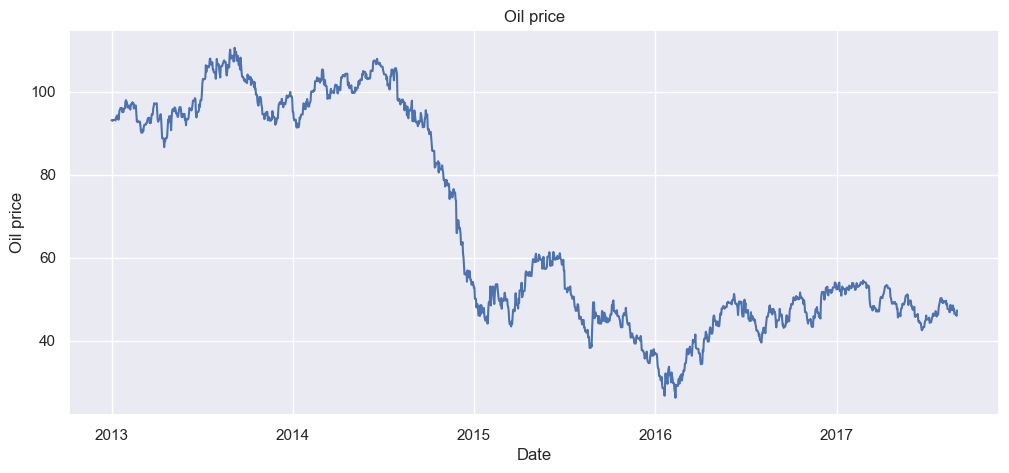

In [17]:
#### We can see there is a oil shock between 2014 and 2015. After that it slowly decreased until it hits the bottom in 2016.
### After that it stayed stable up until the last day of the dataset.
plt.figure(figsize = (12,5))
sns.lineplot(oil_df2, x = 'date', y = 'dcoilwtico')
plt.title('Oil price')
plt.xlabel('Date')
plt.ylabel('Oil price')
plt.show()

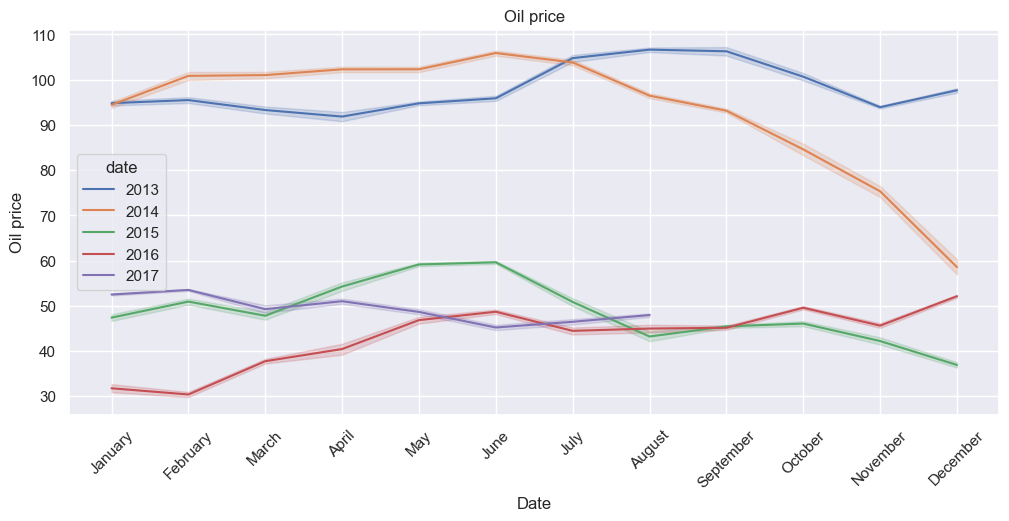

In [18]:
#### We can also check for seasonality between the years. We can't clearly see any monthly pattern, so we use can use a seasonal decompose
#### to evaluate the other seasonalities
plt.figure(figsize = (12,5))
(sns.lineplot(oil_df2, 
              x = oil_df2['date'].dt.strftime('%B'), 
              y = 'dcoilwtico', 
              hue = oil_df2['date'].dt.strftime('%Y'),
              ))
plt.title('Oil price')
plt.xlabel('Date')
plt.ylabel('Oil price')
plt.xticks(rotation = 45)
plt.show()

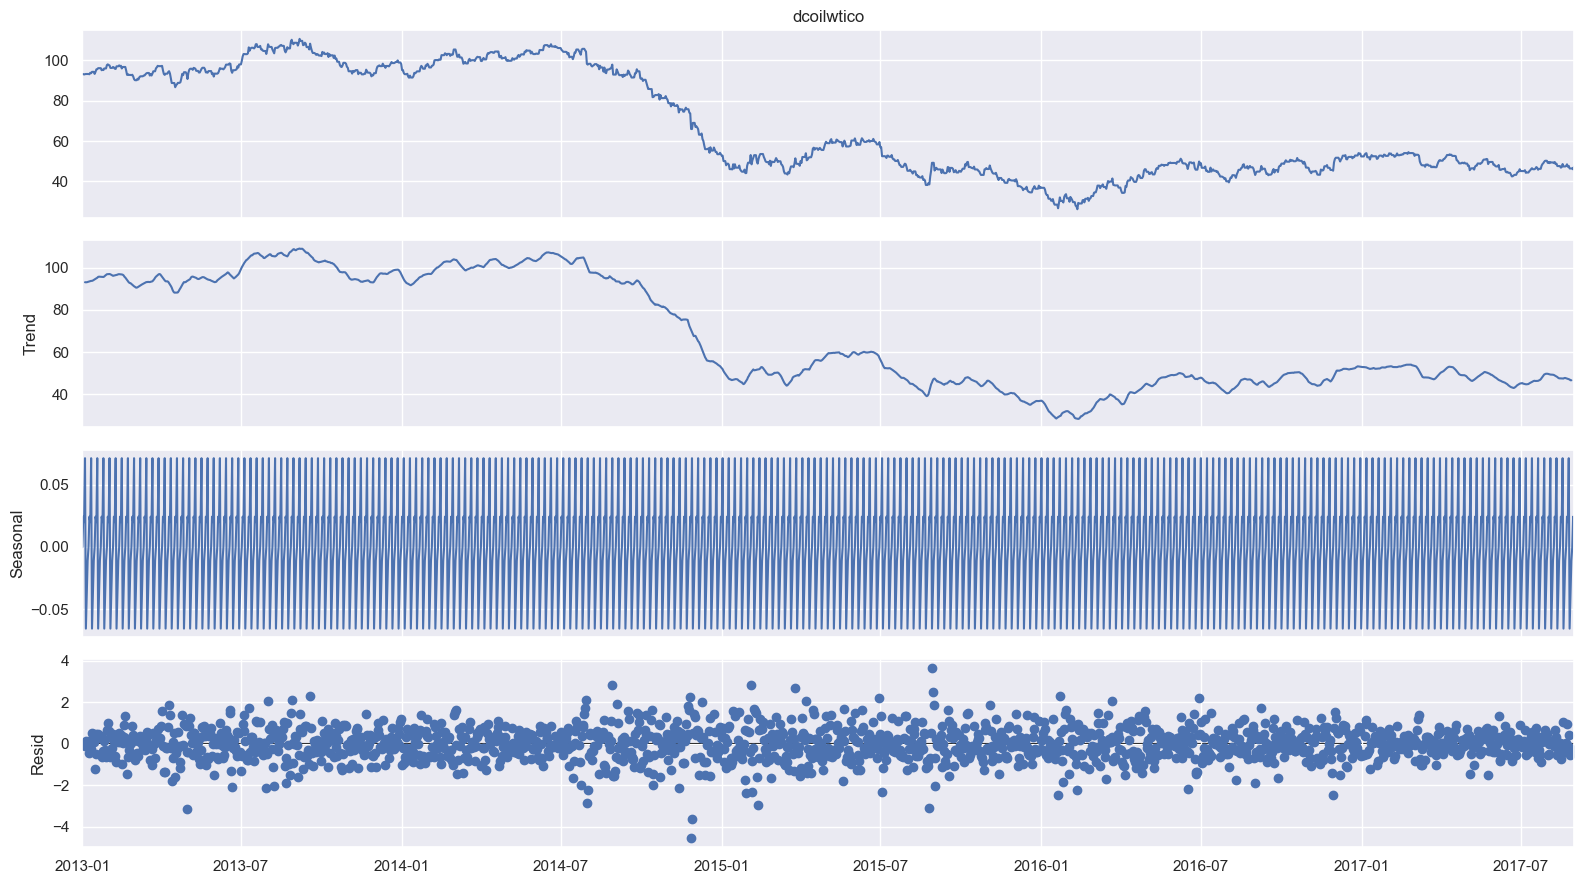

In [19]:
#Test for Seasonality
# Perform seasonal decomposition
oil_df3 = oil_df2.copy()#[oil_df2['date'].between('2013-01-01','2014-01-01')].copy()
oil_df3.set_index('date', inplace = True)
oil_df3.index.freq = 'd'
res = sm.tsa.seasonal_decompose(oil_df3.dcoilwtico)

# Create a larger figure and plot the decomposed components
fig = res.plot()
fig.set_size_inches((16,9))
fig.tight_layout()
plt.show()

#### Evaluating total sales

In [20]:
sales_df = train_df.copy()
sales_df['date'] = pd.to_datetime(sales_df['date'])

In [21]:
total_sales = sales_df.groupby(['date'], as_index = False)[['sales','onpromotion']].sum()

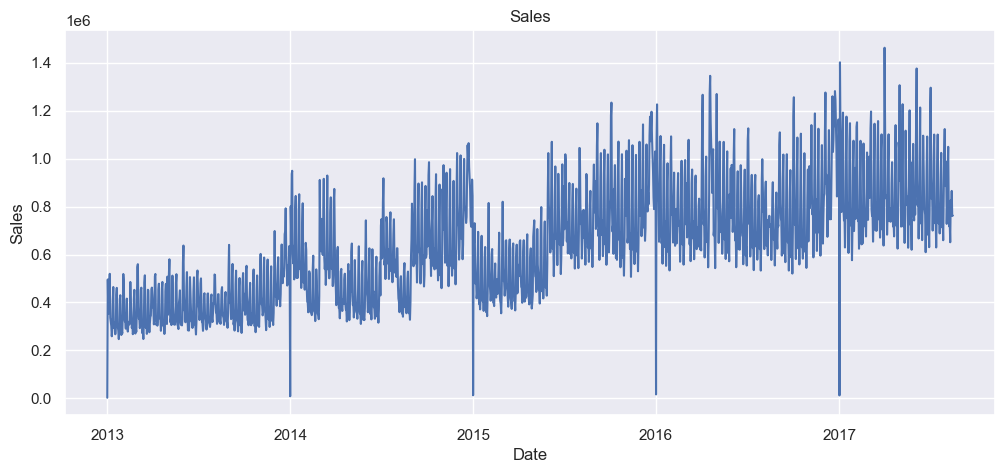

In [22]:
#### We can see there is a oil shock between 2014 and 2015. After that it slowly decreased until it hits the bottom in 2016.
### After that it stayed stable up until the last day of the dataset.
plt.figure(figsize = (12,5))
sns.lineplot(total_sales, x = 'date', y = 'sales')
plt.title('Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

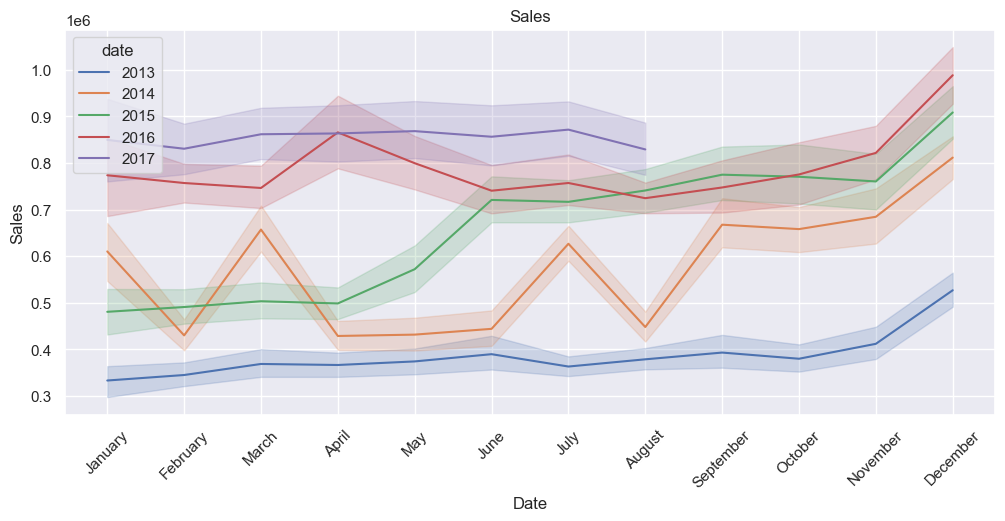

In [23]:
#### We can also check for seasonality between the years. We can't clearly see any monthly pattern, so we use can use a seasonal decompose
#### to evaluate the other seasonalities
plt.figure(figsize = (12,5))
(sns.lineplot(total_sales, 
              x = total_sales['date'].dt.strftime('%B'), 
              y = 'sales', 
              hue = total_sales['date'].dt.strftime('%Y'),
              ))
plt.title('Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation = 45)
plt.show()

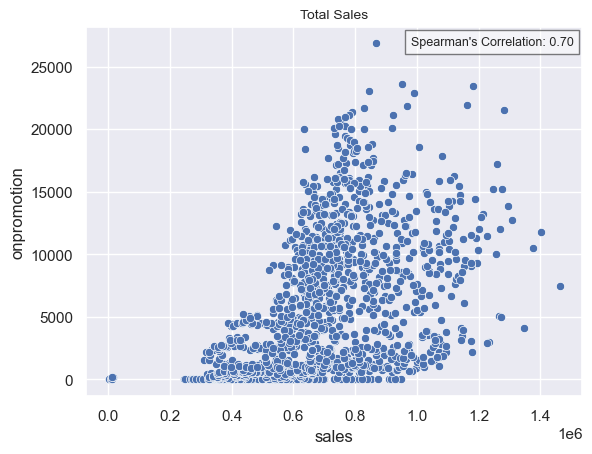

In [24]:
sns.scatterplot(data=total_sales, x='sales', y='onpromotion')

# Spearman correlation
spearman_correlation = total_sales['sales'].corr(total_sales['onpromotion'], method='spearman')
textstr = f"Spearman's Correlation: {spearman_correlation:.2f}"

# Add correlation text

plt.text(
    x=total_sales['sales'].max() * 0.67,
    y=total_sales['onpromotion'].max() * 0.995,
    s=textstr,
    fontsize=9,
    bbox=dict(facecolor='white', alpha=0.5, edgecolor='black')
)
plt.title(f"Total Sales", fontsize=10)
plt.show()

In [25]:
### Evaluating stationarity in the series -> It is a non-stationary series. We can differentiate and check again
check_stationarity(total_sales['sales'])

ADF Statistic: -2.616196
p-value: 0.089696
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Non-stationary


In [26]:
total_sales['dif_sales'] = total_sales['sales'].diff()
total_sales['dif_sales'].fillna(0, inplace = True)

In [27]:
### For models that require a stationary series, we can use the differentiation of the series
check_stationarity(total_sales['dif_sales'])

ADF Statistic: -11.495798
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Stationary


#### Evaluating Sales per product

In [28]:
prd_sales_df = sales_df.groupby(['date','family'], as_index=False)[['sales','onpromotion']].sum()

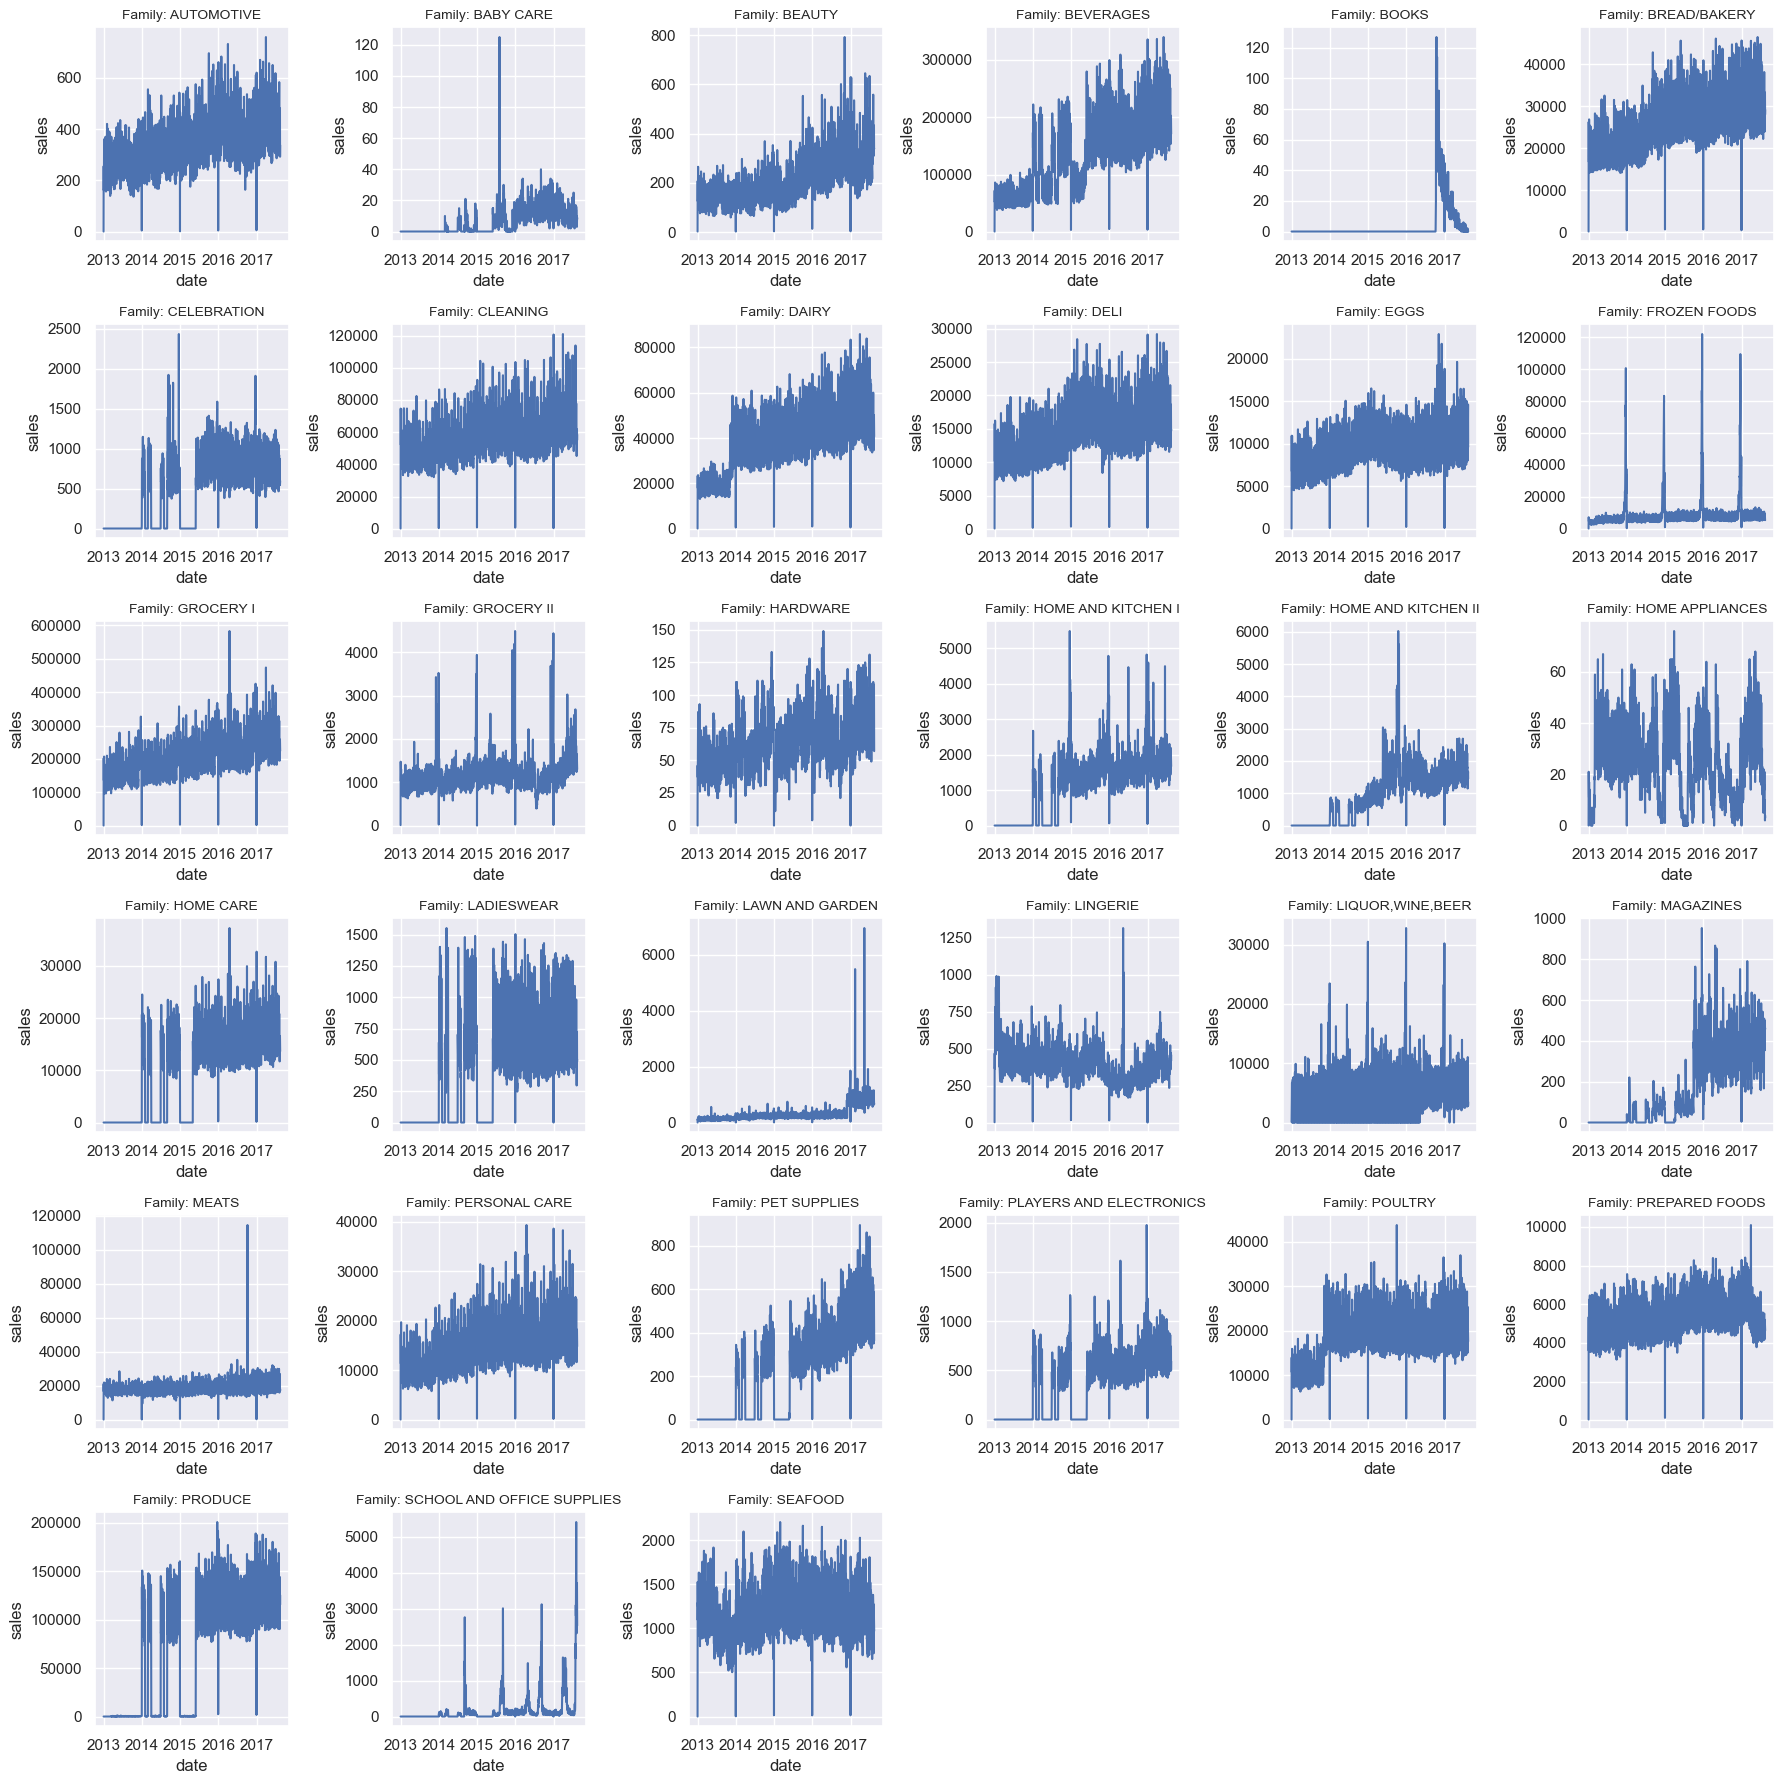

In [29]:
fig, axes = plt.subplots(6, 6, figsize=(18, 18))  # Increased figure size for better visibility
axes = axes.flatten()  # Flatten the 2D array into 1D
j = 0

for i in prd_sales_df['family'].unique():
    if j >= len(axes):
        break  # Avoid index error if more than 36 families

    temp_filter = prd_sales_df[prd_sales_df['family'] == i].copy()

    # Scatter plot
    sns.lineplot(ax=axes[j], data=temp_filter, x='date', y='sales')
    axes[j].set_title(f"Family: {i}", fontsize=10)
    j += 1

# Hide any unused subplots
for k in range(j, len(axes)):
    axes[k].axis('off')

plt.tight_layout()
plt.show()

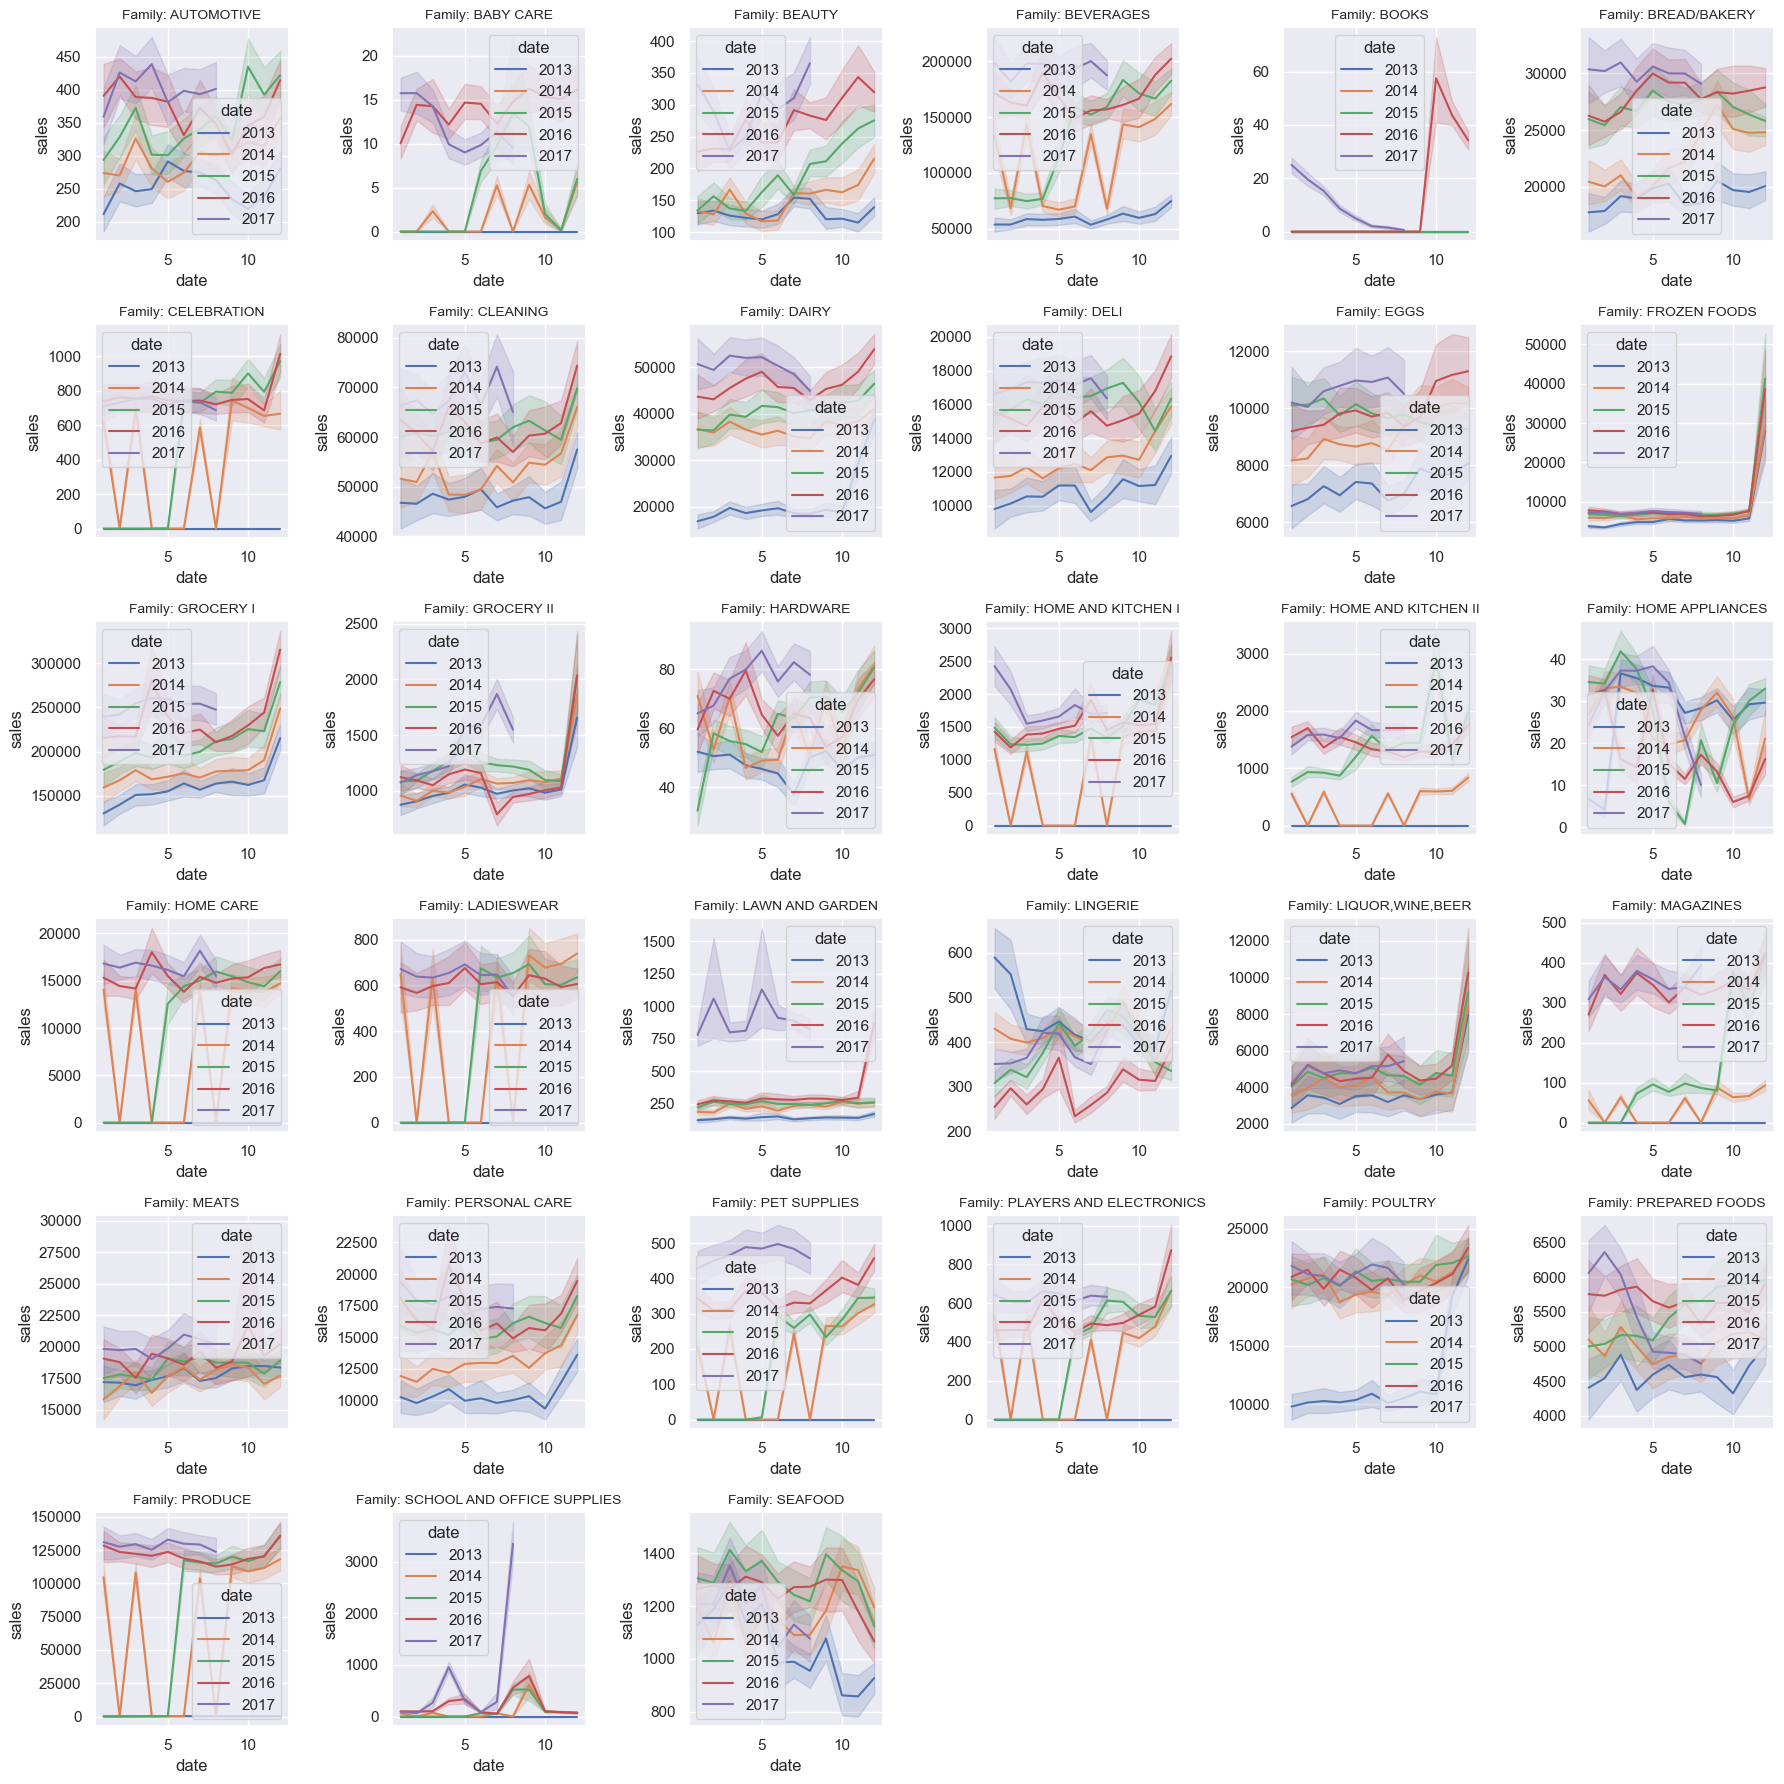

In [30]:
fig, axes = plt.subplots(6, 6, figsize=(18, 18))  # Creation of the subplot based on the amount of product families available
axes = axes.flatten()  # Flatten the 2D array into 1D
j = 0

for i in prd_sales_df['family'].unique():
    if j >= len(axes):
        break  # Avoid index error if more than 36 families

    temp_filter = prd_sales_df[prd_sales_df['family'] == i].copy()

    # Line plot
    (sns.lineplot(ax=axes[j], data = temp_filter, 
              x = temp_filter['date'].dt.month, 
              y = 'sales', 
              hue = temp_filter['date'].dt.strftime('%Y'),
              ))
    axes[j].set_title(f"Family: {i}", fontsize=10)
    j += 1

# Hide any unused subplots
for k in range(j, len(axes)):
    axes[k].axis('off')

plt.tight_layout()
plt.show()

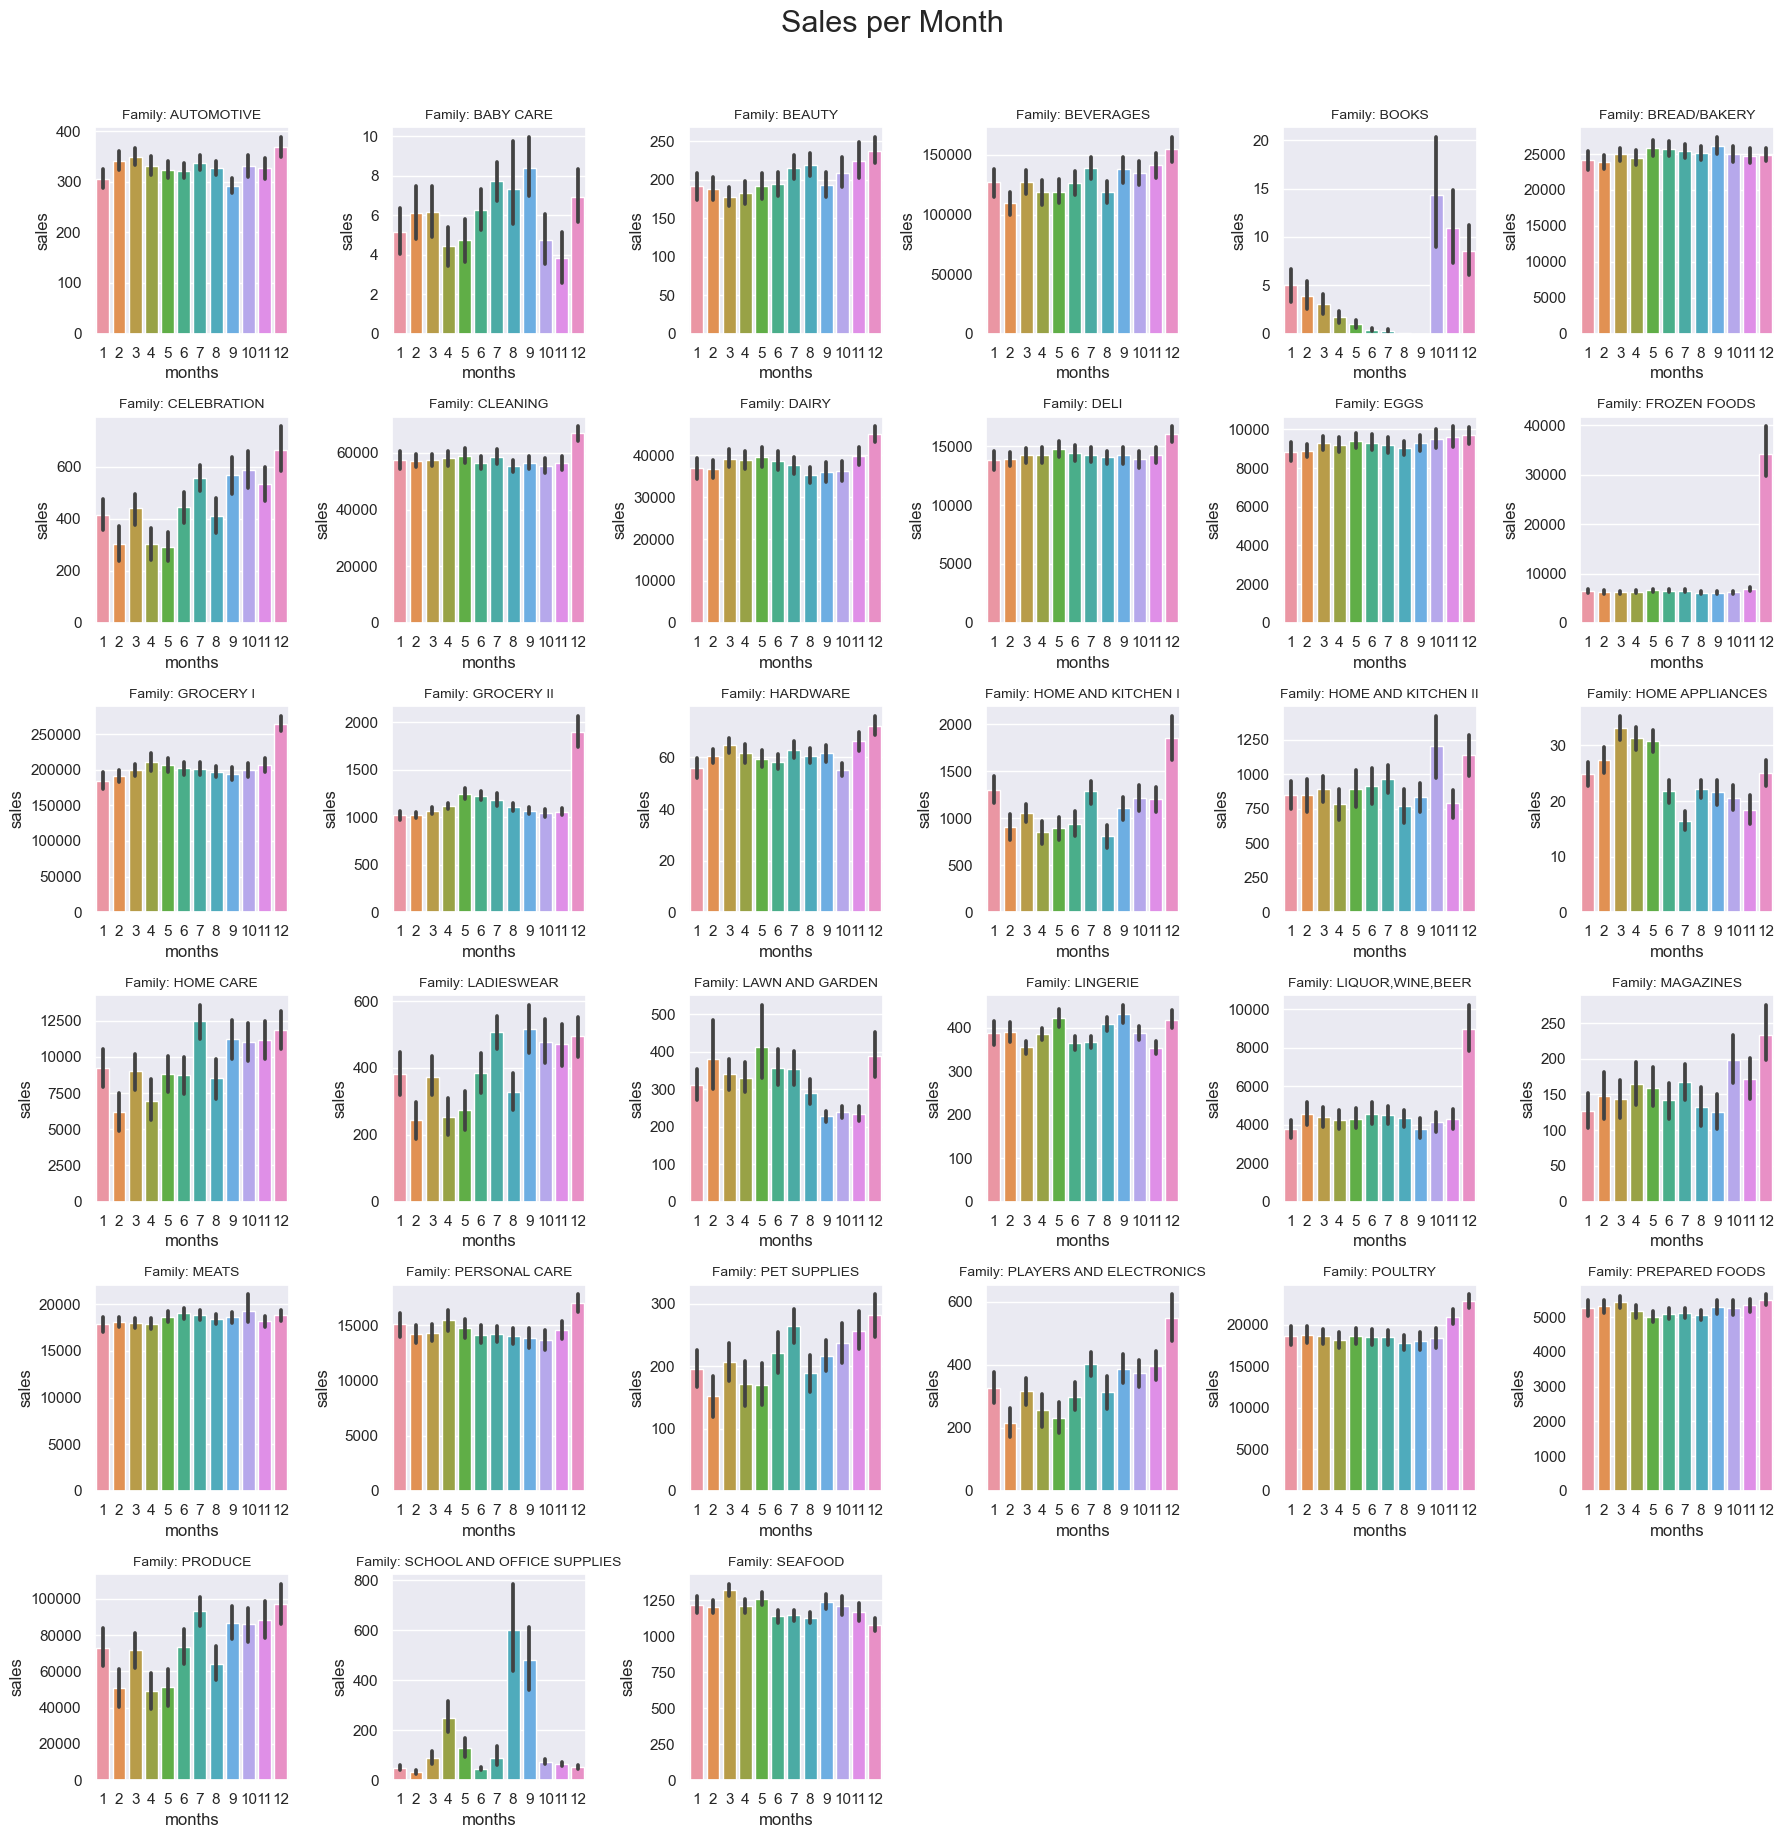

In [31]:
fig, axes = plt.subplots(6, 6, figsize=(18, 18))  # Creation of the subplot based on the amount of product families available
axes = axes.flatten()  # Flatten the 2D array into 1D
j = 0

fig.suptitle("Sales per Month", fontsize = 22, y = 1.02)

for i in prd_sales_df['family'].unique():
    if j >= len(axes):
        break  # Avoid index error if more than 36 families

    temp_filter = prd_sales_df[prd_sales_df['family'] == i].copy()

    # bar plot
    (sns.barplot(ax=axes[j], data = temp_filter, 
              x = temp_filter['date'].dt.month, 
              y = 'sales', 
              ))
    axes[j].set_title(f"Family: {i}", fontsize=10)
    axes[j].set_xlabel('months')
    j += 1

# Hide any unused subplots
for k in range(j, len(axes)):
    axes[k].axis('off')

plt.tight_layout()
plt.show()

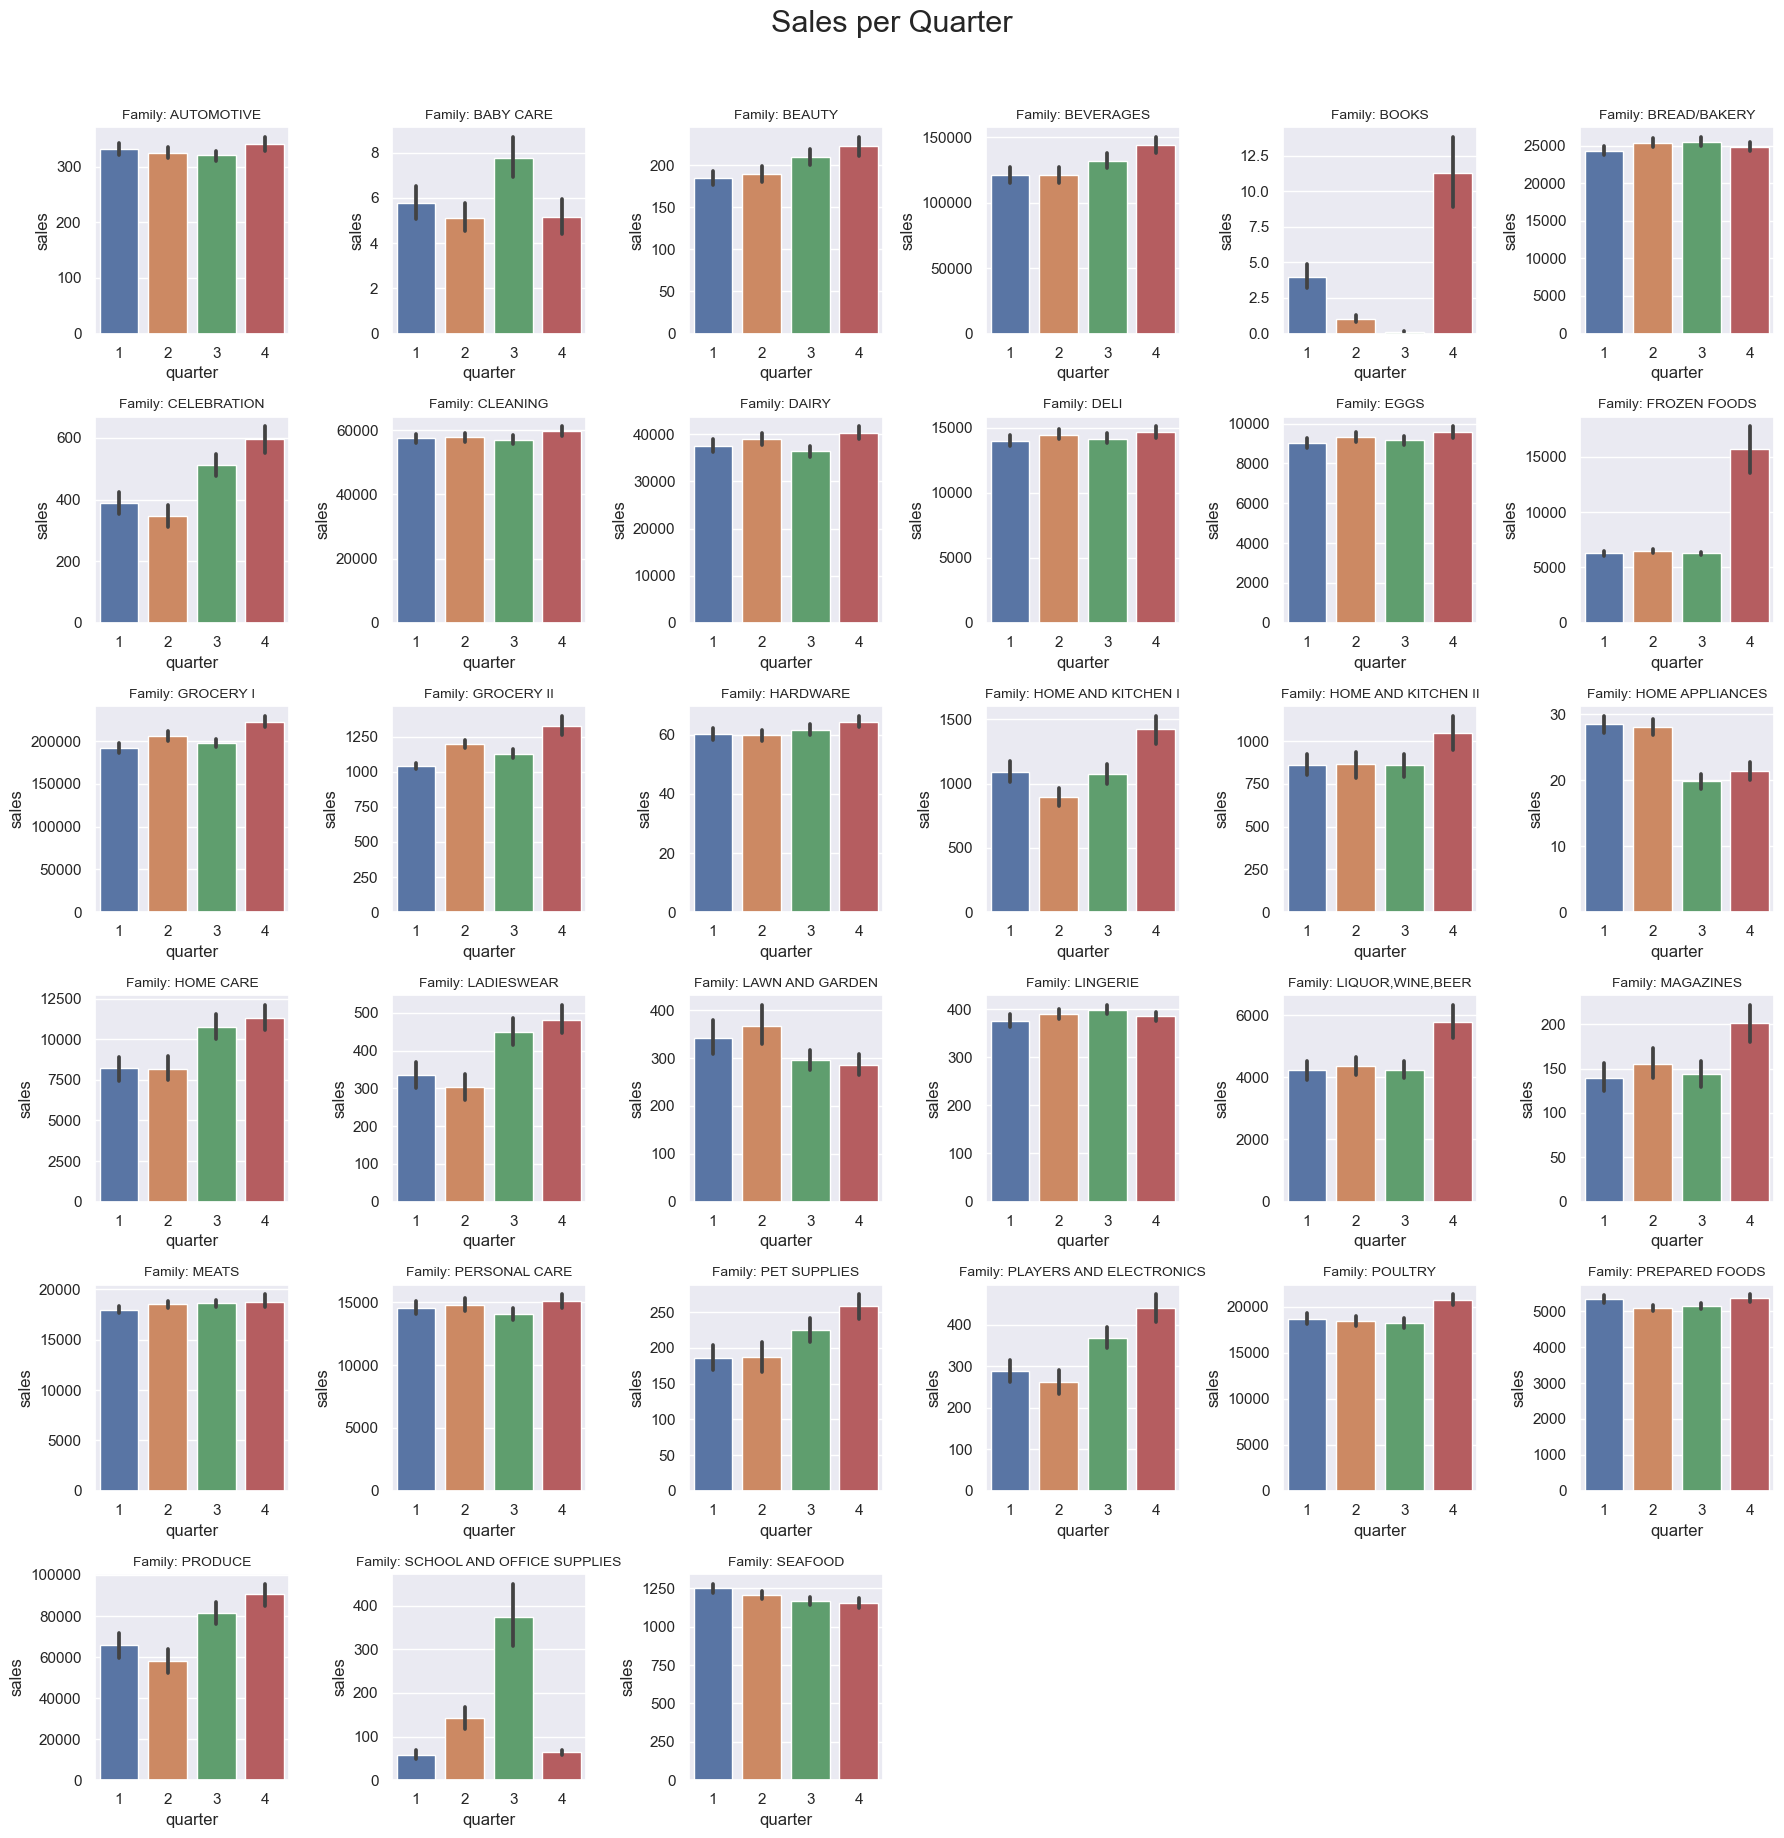

In [32]:
fig, axes = plt.subplots(6, 6, figsize=(18, 18))  # Creation of the subplot based on the amount of product families available
axes = axes.flatten()  # Flatten the 2D array into 1D
j = 0
fig.suptitle("Sales per Quarter", fontsize = 22, y = 1.02)

for i in prd_sales_df['family'].unique():
    if j >= len(axes):
        break  # Avoid index error if more than 36 families

    temp_filter = prd_sales_df[prd_sales_df['family'] == i].copy()

    # Line plot
    (sns.barplot(ax=axes[j], data = temp_filter, 
              x = temp_filter['date'].dt.quarter, 
              y = 'sales', 
              ))
    axes[j].set_title(f"Family: {i}", fontsize=10)
    axes[j].set_xlabel('quarter')
    j += 1

# Hide any unused subplots
for k in range(j, len(axes)):
    axes[k].axis('off')

plt.tight_layout()
plt.show()

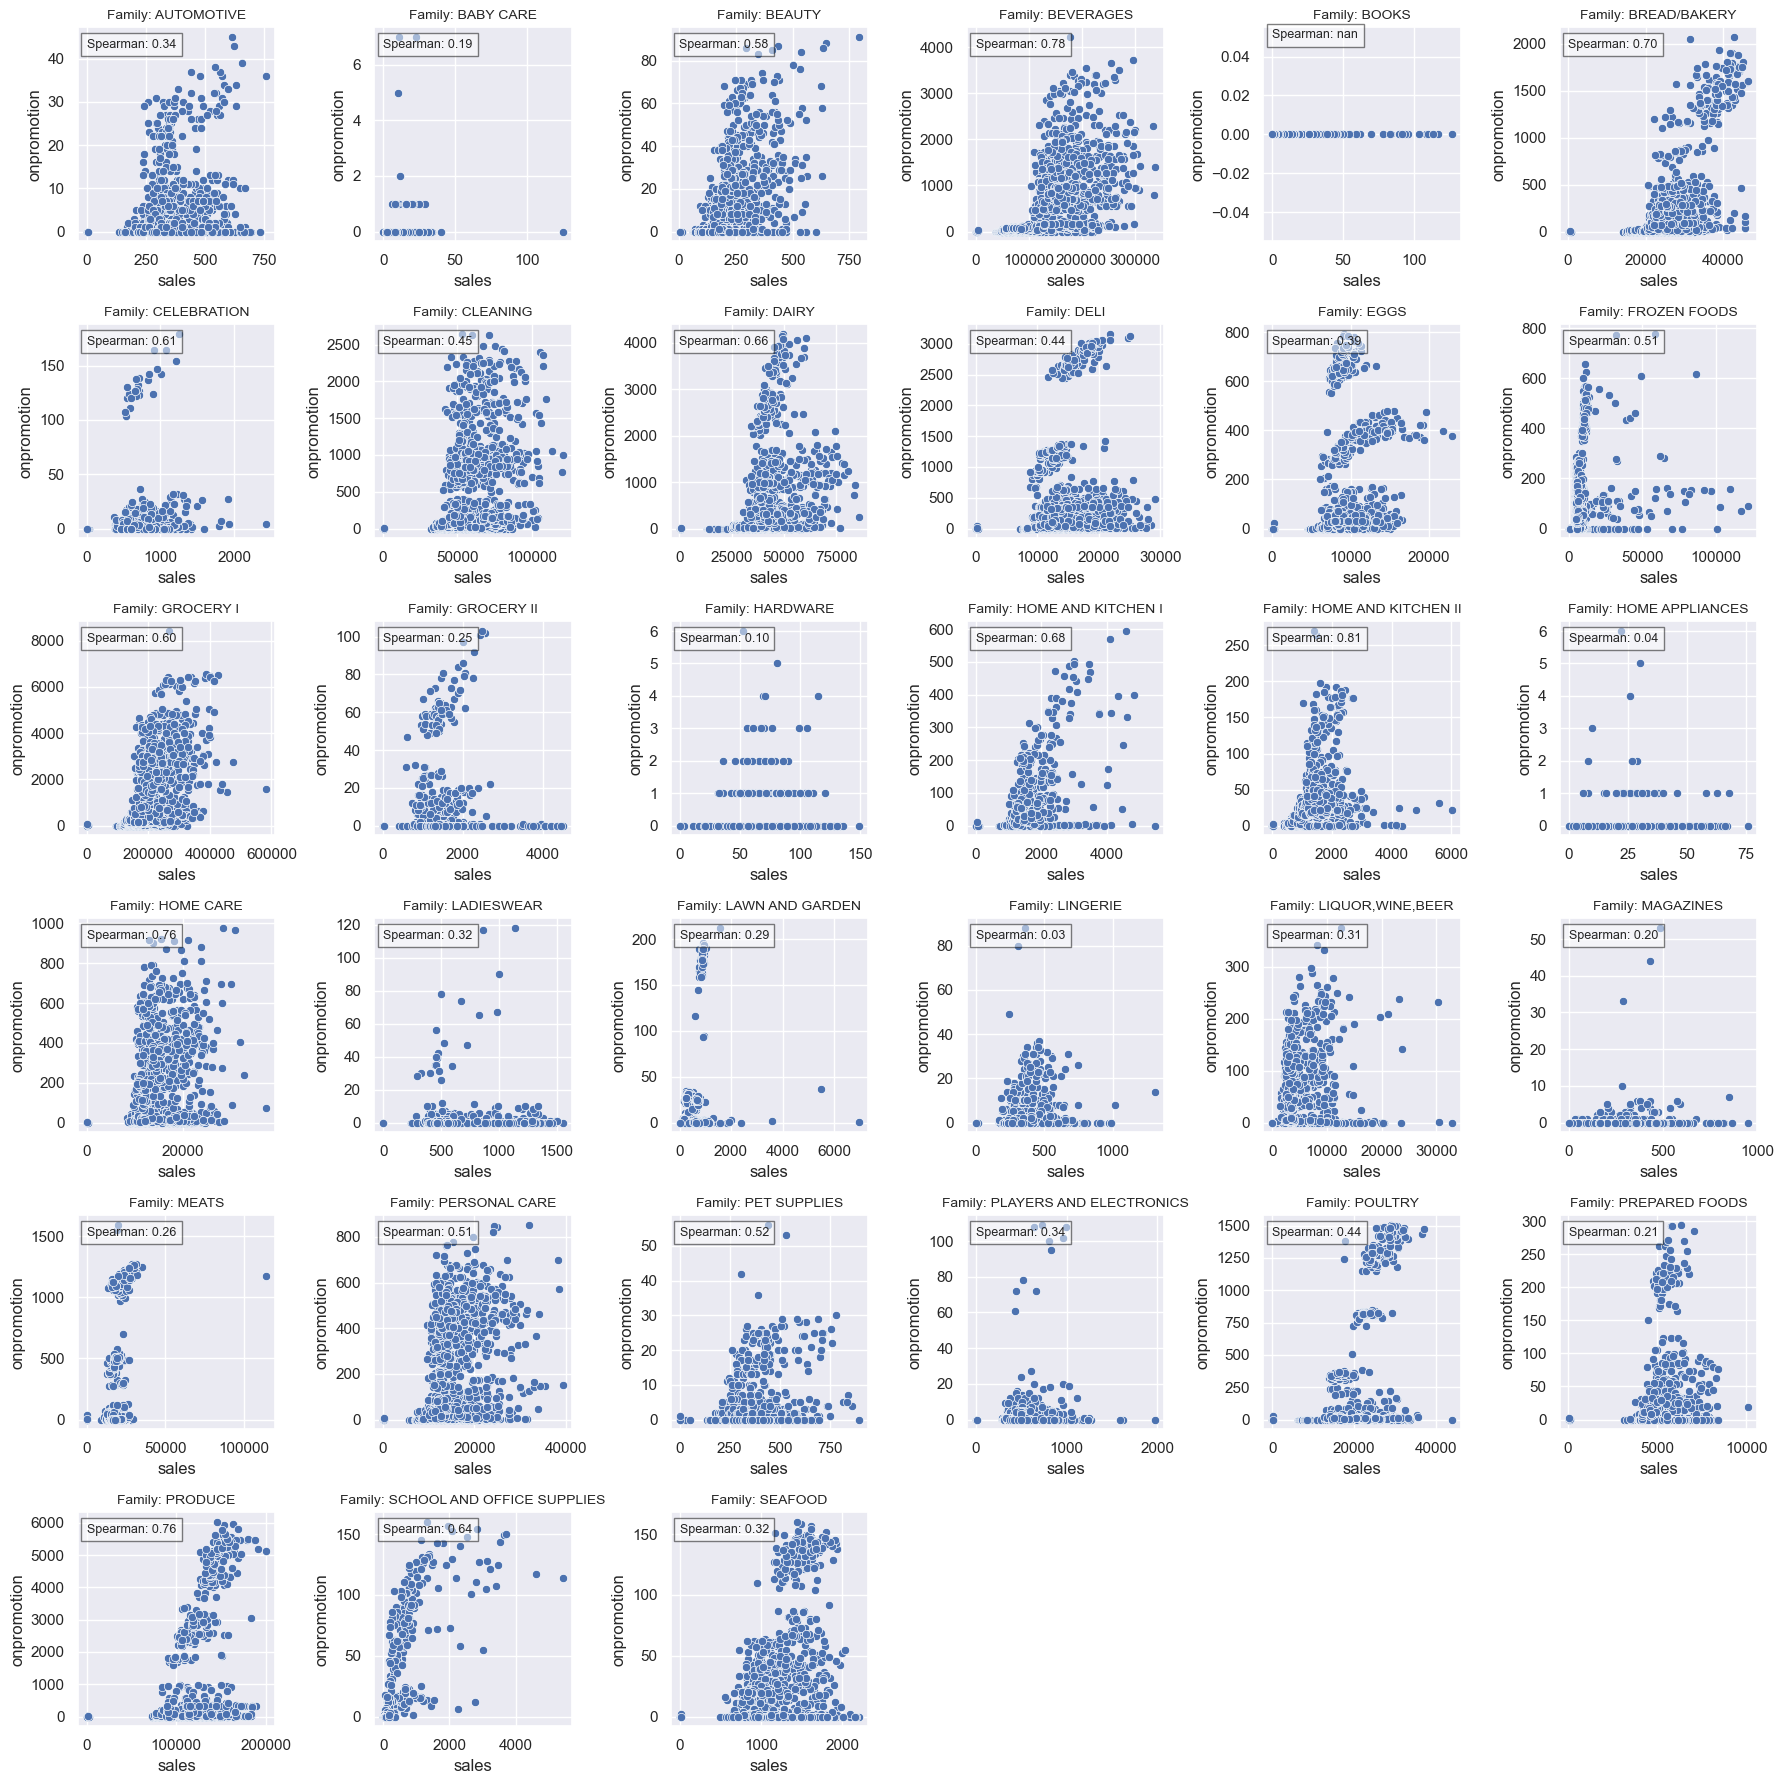

In [33]:
fig, axes = plt.subplots(6, 6, figsize=(18, 18))  # Increased figure size for better visibility
axes = axes.flatten()  # Flatten the 2D array into 1D
j = 0

for i in prd_sales_df['family'].unique():
    if j >= len(axes):
        break  # Avoid index error if more than 36 families

    temp_filter = prd_sales_df[prd_sales_df['family'] == i].copy()

    # Scatter plot
    sns.scatterplot(ax=axes[j], data=temp_filter, x='sales', y='onpromotion')

    # Spearman correlation
    spearman_correlation = temp_filter['sales'].corr(temp_filter['onpromotion'], method='spearman')
    textstr = f"Spearman: {spearman_correlation:.2f}"

    # Add correlation text
    x_pos = temp_filter['sales'].min() * 0.7
    y_min, y_max = axes[j].get_ylim()
    y_pos = y_max * 0.9

    axes[j].text(
        x=x_pos,
        y=y_pos,
        s=textstr,
        fontsize=9,
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='black')
    )
    axes[j].set_title(f"Family: {i}", fontsize=10)
    j += 1

# Hide any unused subplots
for k in range(j, len(axes)):
    axes[k].axis('off')

plt.tight_layout()
plt.show()

In [34]:
#### Creating a table for product performance comparison
### The dataset has a standard of showing every family product per day, even if the product was not sold at the time
### So we get the first sale date and drop everything before that so we have the accurate sales per day
### we also create some sales analysis to evaluate the family performance
mask = prd_sales_df['sales'] != 0
first_sale_date = prd_sales_df.where(mask).groupby('family')['date'].transform('min')
filtered_prd_sl_df = prd_sales_df[prd_sales_df['date'] >= first_sale_date]
prd_rlst = filtered_prd_sl_df.groupby('family', as_index= False).agg({'sales':['mean','sum','median'],'onpromotion':['mean','sum','median'], 'date':['min','count']})
prd_rlst.columns = ['_'.join(i) for i in prd_rlst.columns]
prd_rlst.rename({'family_':'family'},axis = 1, inplace = True)

In [35]:
prd_rlst['sls_per_day'] = prd_rlst['sales_sum'] / prd_rlst['date_count']
prd_rlst['promo_per_day'] = prd_rlst['onpromotion_sum'] / prd_rlst['date_count']

In [36]:
fig = px.scatter(prd_rlst[['family','sls_per_day','promo_per_day']],
                 x = 'sls_per_day',
                 y = 'promo_per_day',
                 hover_name='family',
                 labels=dict(promo_per_day='Promotions per day',sls_per_day='Sales per day'),
                 text = 'family')
fig.update_traces(textposition='top center')
fig.update_layout(
    title={
        'text': 'On Promotion per day x Sales per day scatterplot',
        'x': 0.5,  # Center the title (0 = left, 0.5 = center, 1 = right)
        'xanchor': 'center',
        'font': {
            'size': 20,
            'color': 'black',
            'family': 'Arial'
        }
    }
)
fig.show()

In [37]:
#### Get quarterly sales to find patterns and group the products using K-Means. 
# This way we can try to find patterns between the products
# Important: We normalize the data because we only want the seasonality effects per product
prd_sales_df2 = prd_sales_df.copy()
prd_sales_df2['quarter'] = prd_sales_df2['date'].dt.quarter
prd_sales_df3 = prd_sales_df2.pivot_table(index = 'family',columns = 'quarter',values = 'sales', aggfunc='sum').round(2).reset_index()
prd_sales_df3['total'] = prd_sales_df3.loc[0:,1:].sum(axis = 1).round(2)
for column in prd_sales_df3.loc[0:,1:4].columns:
    prd_sales_df3[column] = prd_sales_df3[column] / prd_sales_df3['total']
prd_sales_df3.drop('total', axis = 1, inplace = True)

In [38]:
df_prd_norm = prd_sales_df3.set_index('family').copy()

#### Applying KMeans
First we run an elbow analysis to find a good number of clusters
Then we fit and evaluate the balance and result of the groups

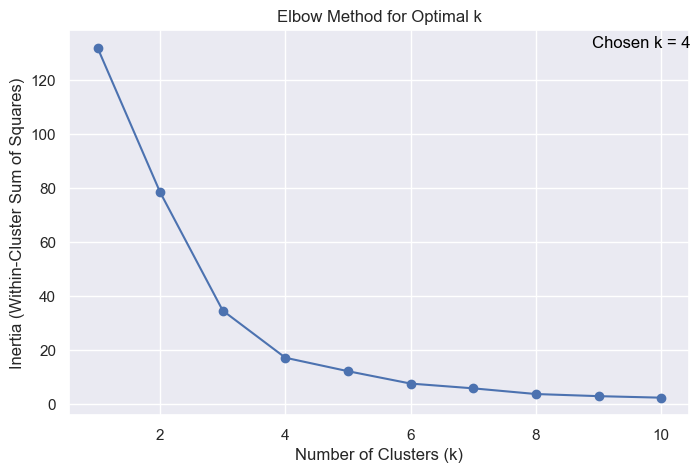

In [39]:
# Scale (just to ensure consistency)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_prd_norm)

# Calculate inertia for k = 1 to 10
inertias = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertias.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
### Adding the k selected based on the elbow analysis
plt.text(
    x = 8.9,
    y = max(inertias),
    s = "Chosen k = 4",
    fontsize = 12,
    color = 'black'
)
plt.show()

In [40]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_prd_norm)
kmeans = KMeans(n_clusters=4, random_state = 265)
clusters = kmeans.fit_predict(scaled_data)
df_prd_norm['cluster'] = clusters

#### Running some evaluation scores for the KMeans clustering

In [41]:
score = silhouette_score(scaled_data, kmeans.labels_)
print("Measures how similar each point is to its own cluster vs. others. Values range from -1 to 1.\n"
       f"Silhouette Score (k=4): {score:.3f} \n"
      "~1 = better-defined clusters / ~0 -> overlapping clusters / < 0 -> likely incorrect clustering")


Measures how similar each point is to its own cluster vs. others. Values range from -1 to 1.
Silhouette Score (k=4): 0.495 
~1 = better-defined clusters / ~0 -> overlapping clusters / < 0 -> likely incorrect clustering


In [42]:
ch_score = calinski_harabasz_score(scaled_data, kmeans.labels_)
print("Ratio of between-cluster dispersion to within-cluster dispersion.\n"
      f"Calinski-Harabasz Score (k=4): {ch_score:.2f}\n"
      "Higher = better clusters (more separated and tight)")

Ratio of between-cluster dispersion to within-cluster dispersion.
Calinski-Harabasz Score (k=4): 64.71
Higher = better clusters (more separated and tight)


In [43]:
db_score = davies_bouldin_score(scaled_data, kmeans.labels_)
print("Measures average similarity between each cluster and its most similar one. \n"
    f"Davies-Bouldin Score (k=4): {db_score:.3f} \n"
    "Lower = better clusters")

Measures average similarity between each cluster and its most similar one. 
Davies-Bouldin Score (k=4): 0.410 
Lower = better clusters


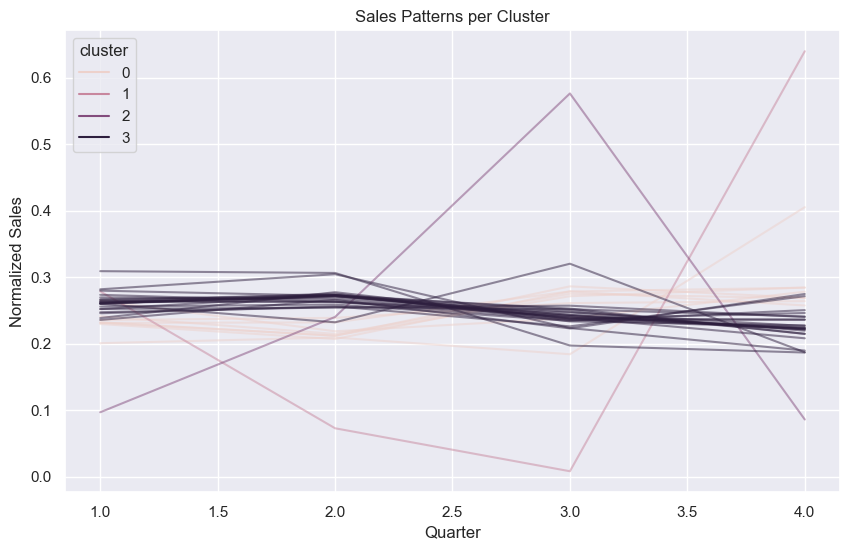

In [44]:
# Visualization: Clustered patterns
df_melted = df_prd_norm.reset_index().melt(id_vars=['family', 'cluster'], var_name='quarter', value_name='normalized_sales')

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_melted, x='quarter', y='normalized_sales', hue='cluster', estimator=None, units='family', alpha=0.5)
plt.title("Sales Patterns per Cluster")
plt.ylabel("Normalized Sales")
plt.xlabel("Quarter")
plt.show()

#### We can also run a PCA to see the cluster split

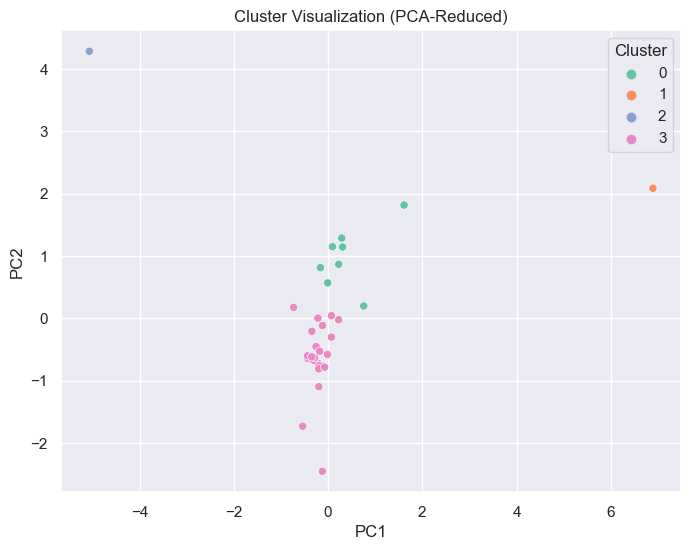

In [45]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(scaled_data)

plt.figure(figsize=(8,6))
sns.scatterplot(x=reduced[:,0], y=reduced[:,1], hue=kmeans.labels_, palette='Set2')
plt.title("Cluster Visualization (PCA-Reduced)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

#### We can use the product clustering later as a feature enginner and evaluate the feature importance
The PCA shows that there are 2 main groups that the products are mainly splits, and the cluster 1 and 2
are outliers

The cluster 1 is BOOKS, which had the sales mostly concentrated in the 4th quarter

The cluster 2 is School and Office supplies, which is probably correlated with school start

In [46]:
df_prd_norm.query('cluster.isin([1,2])')

quarter                            1         2         3         4  cluster
family                                                                     
BOOKS                       0.278813  0.073004  0.008388  0.639795        1
SCHOOL AND OFFICE SUPPLIES  0.097087  0.240364  0.576345  0.086204        2

#### Evaluating Sales and Holidays relationship
Here we are looking for the impact of holidays in the sales per region

There are more than one approach to model the holidays impact in sales

For now we will proceed with the assumption that each holiday impacts the sales similarly

Another approach would be to create dummies based on each holiday and evaluate the feature imporance;
Which we can also explore later

In [47]:
#### First lets evaluate the relationship of total sales and national holidays
#### We will create a binary column to show it is an national holiday

### Adapt the dataframe
national_holidays = holidays_df4[holidays_df4['locale'] == 'National'][['date','locale_name']].copy()
national_holidays['date'] = pd.to_datetime(national_holidays['date'])

### Merge sales and national holiday dataframe
ttl_sls_nat_hlds = total_sales.iloc[0:,0:3].merge(national_holidays, how = 'left', on = 'date')

### Rename the column and create the binary values
ttl_sls_nat_hlds['locale_name'] = pd.get_dummies(ttl_sls_nat_hlds['locale_name'])
ttl_sls_nat_hlds.rename({'locale_name':'is_holiday'}, axis = 1, inplace = True)

ttl_sls_nat_hlds

date          sales  onpromotion  is_holiday
0    2013-01-01    2511.618999            0        True
1    2013-01-02  496092.417944            0       False
2    2013-01-03  361461.231124            0       False
3    2013-01-04  354459.677093            0       False
4    2013-01-05  477350.121229            0        True
...         ...            ...          ...         ...
1679 2017-08-11  826373.722022        14179        True
1680 2017-08-12  792630.535079         8312       False
1681 2017-08-13  865639.677471         9283       False
1682 2017-08-14  760922.406081         8043       False
1683 2017-08-15  762661.935939        10605       False

[1684 rows x 4 columns]

In [48]:
#### Overview statistics
ttl_sls_nat_hlds.groupby('is_holiday').agg({'sales':['sum','mean','median','std','count']}).round(2)

sales                                       
                     sum       mean     median        std count
is_holiday                                                     
False       9.720172e+08  627918.11  624754.40  227207.58  1548
True        1.016277e+08  747262.61  742923.22  283312.56   136

T-statistic: 4.7794 
P-value: 0.0 
C.I. Low: 70006.3335 
C.I. High: 168682.6706
There is a statistically significant difference between the average sales during holidays x normal days


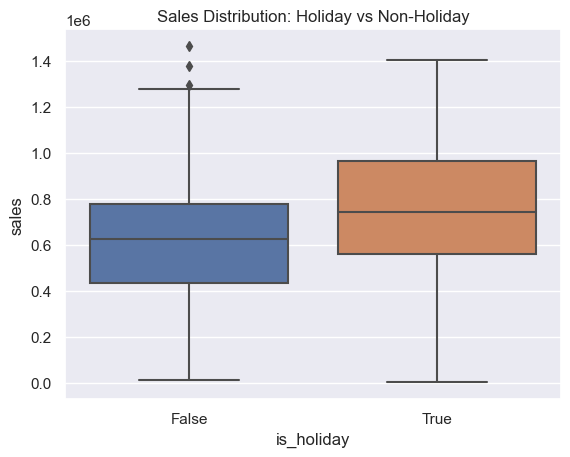

In [49]:
#### We can also test if the holidays had significant impact on sales
sales_holiday = ttl_sls_nat_hlds[ttl_sls_nat_hlds['is_holiday'] == True]['sales']
sales_nonholiday = ttl_sls_nat_hlds[ttl_sls_nat_hlds['is_holiday'] == False]['sales']

t_results = ttest_ind(sales_holiday, sales_nonholiday, equal_var=False)
print(f"T-statistic: {t_results.statistic.round(4)} \n" 
      f"P-value: {t_results.pvalue.round(4)} \n"
      f"C.I. Low: {t_results.confidence_interval(confidence_level=0.95)[0].round(4)} \n"
      f"C.I. High: {t_results.confidence_interval(confidence_level=0.95)[1].round(4)}")

if t_results.pvalue >= 0.05:
    print('There is not enough statistical difference between the two averages')
else:
    print('There is a statistically significant difference between the average sales during holidays x normal days')

### With this we can conclude with 95% of CI that holidays have a significant impact on sales

#### It is possible also to see the pattern with a box-plot
sns.boxplot(x='is_holiday', y='sales', data=ttl_sls_nat_hlds)
plt.title('Sales Distribution: Holiday vs Non-Holiday')
plt.show()

In [50]:
#### There are more than a holiday per day in some regions to check the effects of local holidays
(holidays_df4[holidays_df4['locale'] != 'National']
 .groupby('date')[['locale']].nunique()
 .sort_values(by = 'locale', ascending = False))

locale
date              
2017-06-25       2
2015-06-25       2
2016-06-25       2
2012-06-25       2
2014-06-25       2
...            ...
2014-04-12       1
2014-04-14       1
2014-04-21       1
2014-05-12       1
2017-12-22       1

[152 rows x 1 columns]

In [51]:
#### There are more than a holiday per day in some regions to check the effects of local holidays
local_holidays = (holidays_df4[holidays_df4['locale'] == 'Local'][['date','locale_name']]
                  .drop_duplicates())
local_holidays['is_local_hld'] = True
local_holidays['date'] = pd.to_datetime(local_holidays['date'])

In [52]:
#### There are more than a holiday per day in some regions to check the effects of regional holidays
regional_holidays = (holidays_df4[holidays_df4['locale'] == 'Regional'][['date','locale_name']]
                  .drop_duplicates())
regional_holidays['is_regional_hld'] = True
regional_holidays['date'] = pd.to_datetime(regional_holidays['date'])

In [53]:
#### There are more than a holiday per day in some regions to check the effects of national holidays
national_holidays = (holidays_df4[holidays_df4['locale'] == 'National'][['date','locale_name']]
                  .drop_duplicates())
national_holidays['is_national_hld'] = True
national_holidays['date'] = pd.to_datetime(national_holidays['date'])

In [54]:
#### Lets do the same test for the other holidays
# Get the sales data per store per day
str_sls_temp = sales_df.groupby(['date','store_nbr'], as_index = False)['sales'].sum()

# Merge with stores information to connect to other tables
str_sls_temp = str_sls_temp.merge(stores_df[['store_nbr','city','state']], how = 'left', on = 'store_nbr')

# Merge with local, regional and national holidays and create a boolean approach
str_sls_temp = str_sls_temp.merge(local_holidays, how = 'left', left_on = ['date','city'], right_on = ['date','locale_name'])
str_sls_temp = str_sls_temp.merge(regional_holidays, how = 'left', left_on = ['date','state'], right_on = ['date','locale_name'])
str_sls_temp = str_sls_temp.merge(national_holidays, how = 'left', left_on = ['date'], right_on = ['date'])

# Drop the columns that will not be used and fill NaN values
str_sls_temp.drop(['locale_name_x','locale_name_y', 'locale_name'], axis = 1, inplace=True)
str_sls_temp['is_local_hld'].fillna(False, inplace = True)
str_sls_temp['is_regional_hld'].fillna(False, inplace = True)
str_sls_temp['is_national_hld'].fillna(False, inplace = True)

# Create a column with a is_holiday approach
str_sls_temp['is_holiday'] = str_sls_temp['is_local_hld'] + str_sls_temp['is_regional_hld'] + str_sls_temp['is_national_hld']

In [55]:
str_sls_temp
#### Overview statistics
str_sls_temp.groupby('is_holiday').agg({'sales':['sum','mean','median','std','count']}).round(2)

sales                                     
                     sum      mean    median       std  count
is_holiday                                                   
False       9.668282e+08  11618.30   9210.16   9695.23  83216
True        1.068167e+08  13836.36  10744.19  11947.06   7720

T-statistic: 15.836 
P-value: 0.0 
C.I. Low: 1943.5044 
C.I. High: 2492.6254
There is a statistically significant difference between the average sales during holidays x normal days


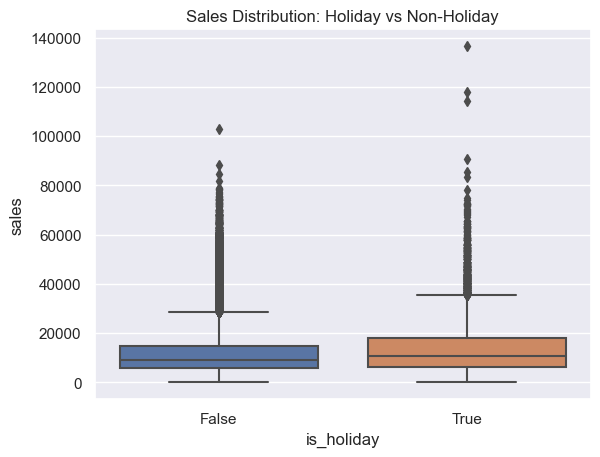

In [56]:
#### We can reuse the same approach to see if considering all holidays, it impacts the sales
sales_holiday = str_sls_temp[str_sls_temp['is_holiday'] == True]['sales']
sales_nonholiday = str_sls_temp[str_sls_temp['is_holiday'] == False]['sales']

t_results = ttest_ind(sales_holiday, sales_nonholiday, equal_var=False)
print(f"T-statistic: {t_results.statistic.round(4)} \n" 
      f"P-value: {t_results.pvalue.round(4)} \n"
      f"C.I. Low: {t_results.confidence_interval(confidence_level=0.95)[0].round(4)} \n"
      f"C.I. High: {t_results.confidence_interval(confidence_level=0.95)[1].round(4)}")

if t_results.pvalue >= 0.05:
    print('There is not enough statistical difference between the two averages')
else:
    print('There is a statistically significant difference between the average sales during holidays x normal days')

### With this we can conclude with 95% of CI that holidays have a significant impact on sales

#### It is possible also to see the pattern with a box-plot
sns.boxplot(x='is_holiday', y='sales', data=str_sls_temp)
plt.title('Sales Distribution: Holiday vs Non-Holiday')
plt.show()

T-statistic: -4.7092 
P-value: 0.0001 
C.I. Low: -5788.0265 
C.I. High: -2286.6892
There is a statistically significant difference between the average sales during regional holidays x normal days


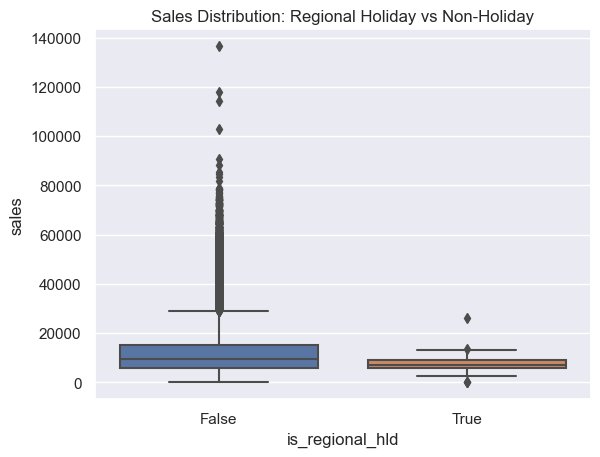

In [57]:
#### Recreating the analysis for regional holidays
sales_holiday = str_sls_temp[str_sls_temp['is_regional_hld'] == True]['sales']
sales_nonholiday = str_sls_temp[str_sls_temp['is_holiday'] == False]['sales']

t_results = ttest_ind(sales_holiday, sales_nonholiday, equal_var=False)
print(f"T-statistic: {t_results.statistic.round(4)} \n" 
      f"P-value: {t_results.pvalue.round(4)} \n"
      f"C.I. Low: {t_results.confidence_interval(confidence_level=0.95)[0].round(4)} \n"
      f"C.I. High: {t_results.confidence_interval(confidence_level=0.95)[1].round(4)}")

if t_results.pvalue >= 0.05:
    print('There is not enough statistical difference between the two averages')
else:
    print('There is a statistically significant difference between the average sales during regional holidays x normal days')

### With this we can conclude with 95% of CI that holidays have a significant impact on sales

#### It is possible also to see the pattern with a box-plot
sns.boxplot(x='is_regional_hld', y='sales', data=str_sls_temp)
plt.title('Sales Distribution: Regional Holiday vs Non-Holiday')
plt.show()

T-statistic: 3.6173 
P-value: 0.0003 
C.I. Low: 1130.134 
C.I. High: 3822.8643
There is a statistically significant difference between the average sales during local holidays x normal days


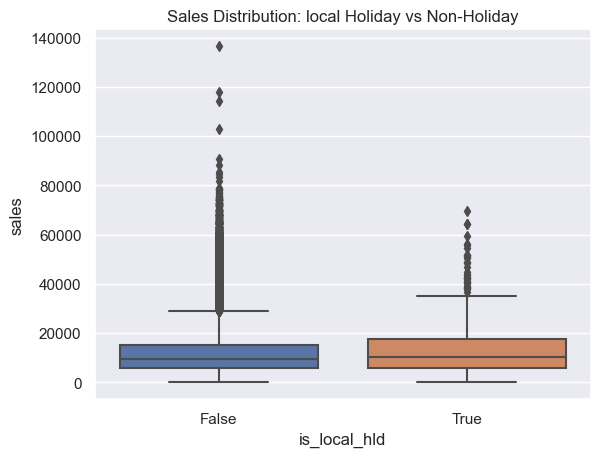

In [58]:
#### Recreating the analysis for local holidays
sales_holiday = str_sls_temp[str_sls_temp['is_local_hld'] == True]['sales']
sales_nonholiday = str_sls_temp[str_sls_temp['is_holiday'] == False]['sales']

t_results = ttest_ind(sales_holiday, sales_nonholiday, equal_var=False)
print(f"T-statistic: {t_results.statistic.round(4)} \n" 
      f"P-value: {t_results.pvalue.round(4)} \n"
      f"C.I. Low: {t_results.confidence_interval(confidence_level=0.95)[0].round(4)} \n"
      f"C.I. High: {t_results.confidence_interval(confidence_level=0.95)[1].round(4)}")

if t_results.pvalue >= 0.05:
    print('There is not enough statistical difference between the two averages')
else:
    print('There is a statistically significant difference between the average sales during local holidays x normal days')

### With this we can conclude with 95% of CI that holidays have a significant impact on sales

#### It is possible also to see the pattern with a box-plot
sns.boxplot(x='is_local_hld', y='sales', data=str_sls_temp)
plt.title('Sales Distribution: local Holiday vs Non-Holiday')
plt.show()

##### We can see that all types of holiday impact the sales
For featuring engineering, we can test 3 approaches:

- Single column with is_holiday boolean
- 3 columns with is_local, is_regional, is_national boolean
- a more complex approach with a dummy for each holiday (requires more study)

#### Evaluating Sales and Oil price relationship
The idea is to find how the changes in the oil price impact the sales of the store.
To do that, we need to evaluate multiple stock indicators, such as correlation with t-1; t-2;
Last 7 days variation; and so on

In [59]:
#### Create the oil features
oil_eval = oil_df3.copy()

# Lag feature
for lag in [1, 2, 3, 5, 10]:
    oil_eval[f'lag_{lag}'] = oil_eval['dcoilwtico'].shift(lag)

# Rolling windows
for w in [3, 5, 10, 20, 30]:
    oil_eval[f'rolling_mean_{w}'] = oil_eval['dcoilwtico'].rolling(window=w).mean()
    oil_eval[f'rolling_std_{w}'] = oil_eval['dcoilwtico'].rolling(window=w).std()
    oil_eval[f'rolling_return_{w}'] = oil_eval['dcoilwtico'].pct_change(w)

oil_eval.dropna(inplace = True)

In [60]:
oil_eval.head(1)

dcoilwtico  lag_1  lag_2  lag_3  lag_5  lag_10  rolling_mean_3  \
date                                                                         
2013-01-31       97.65  97.98  97.62  95.95  95.95   96.09           97.75   

            rolling_std_3  rolling_return_3  rolling_mean_5  ...  \
date                                                         ...   
2013-01-31        0.19975          0.017718           97.03  ...   

            rolling_return_5  rolling_mean_10  rolling_std_10  \
date                                                            
2013-01-31          0.017718           96.275        1.082961   

            rolling_return_10  rolling_mean_20  rolling_std_20  \
date                                                             
2013-01-31           0.016235          95.6235        1.221683   

            rolling_return_20  rolling_mean_30  rolling_std_30  \
date                                                             
2013-01-31           0.043269        94.833333        1.513171   

            rolling_return_30  
date                           
2013-01-31           0.048422  

[1 rows x 21 columns]

In [61]:
### Merge both dataframes
tt_sls_merged_df = total_sales.merge(oil_eval, how = 'inner', on = 'date')

In [62]:
tt_sls_merged_df.iloc[0:,4:].columns

Index(['dcoilwtico', 'lag_1', 'lag_2', 'lag_3', 'lag_5', 'lag_10',
       'rolling_mean_3', 'rolling_std_3', 'rolling_return_3', 'rolling_mean_5',
       'rolling_std_5', 'rolling_return_5', 'rolling_mean_10',
       'rolling_std_10', 'rolling_return_10', 'rolling_mean_20',
       'rolling_std_20', 'rolling_return_20', 'rolling_mean_30',
       'rolling_std_30', 'rolling_return_30'],
      dtype='object')

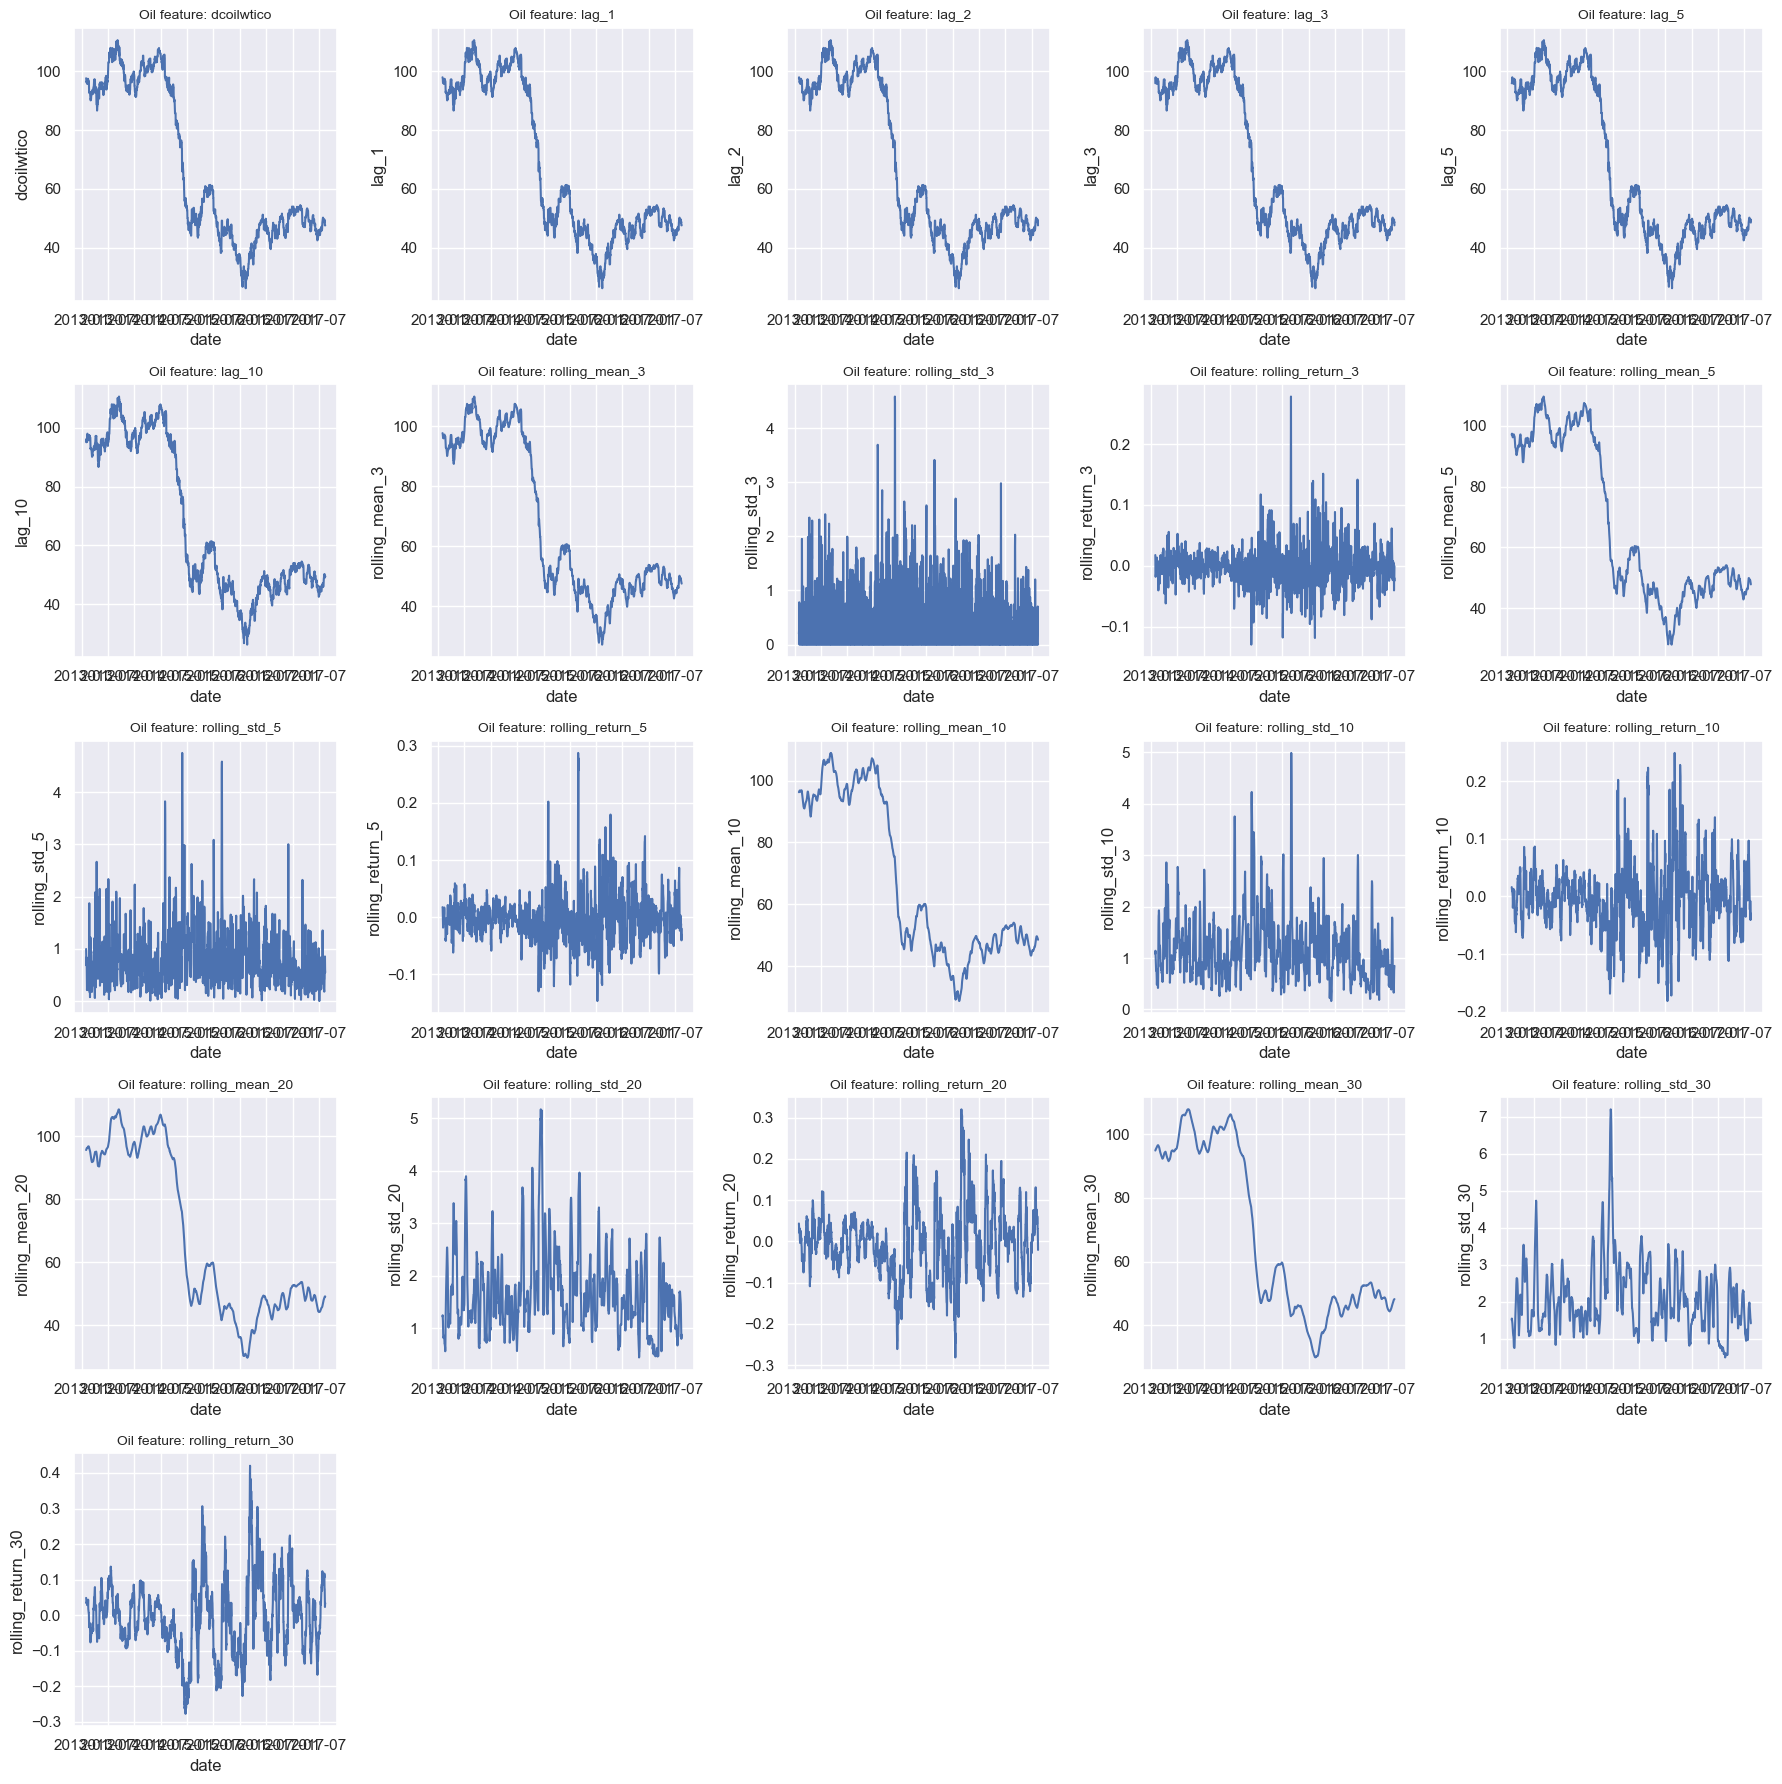

In [63]:
#### Evaluating plot of each oil feature
fig, axes = plt.subplots(5, 5, figsize=(18, 18))  # Increased figure size for better visibility
axes = axes.flatten()  # Flatten the 2D array into 1D
j = 0

for i in tt_sls_merged_df.iloc[0:,4:].columns:
    if j >= len(axes):
        break  # Avoid index error

    # Scatter plot
    sns.lineplot(ax=axes[j], data=tt_sls_merged_df, x='date', y = i)

    axes[j].set_title(f"Oil feature: {i}", fontsize=10)
    j += 1

# Hide any unused subplots
for k in range(j, len(axes)):
    axes[k].axis('off')

plt.tight_layout()
plt.show()

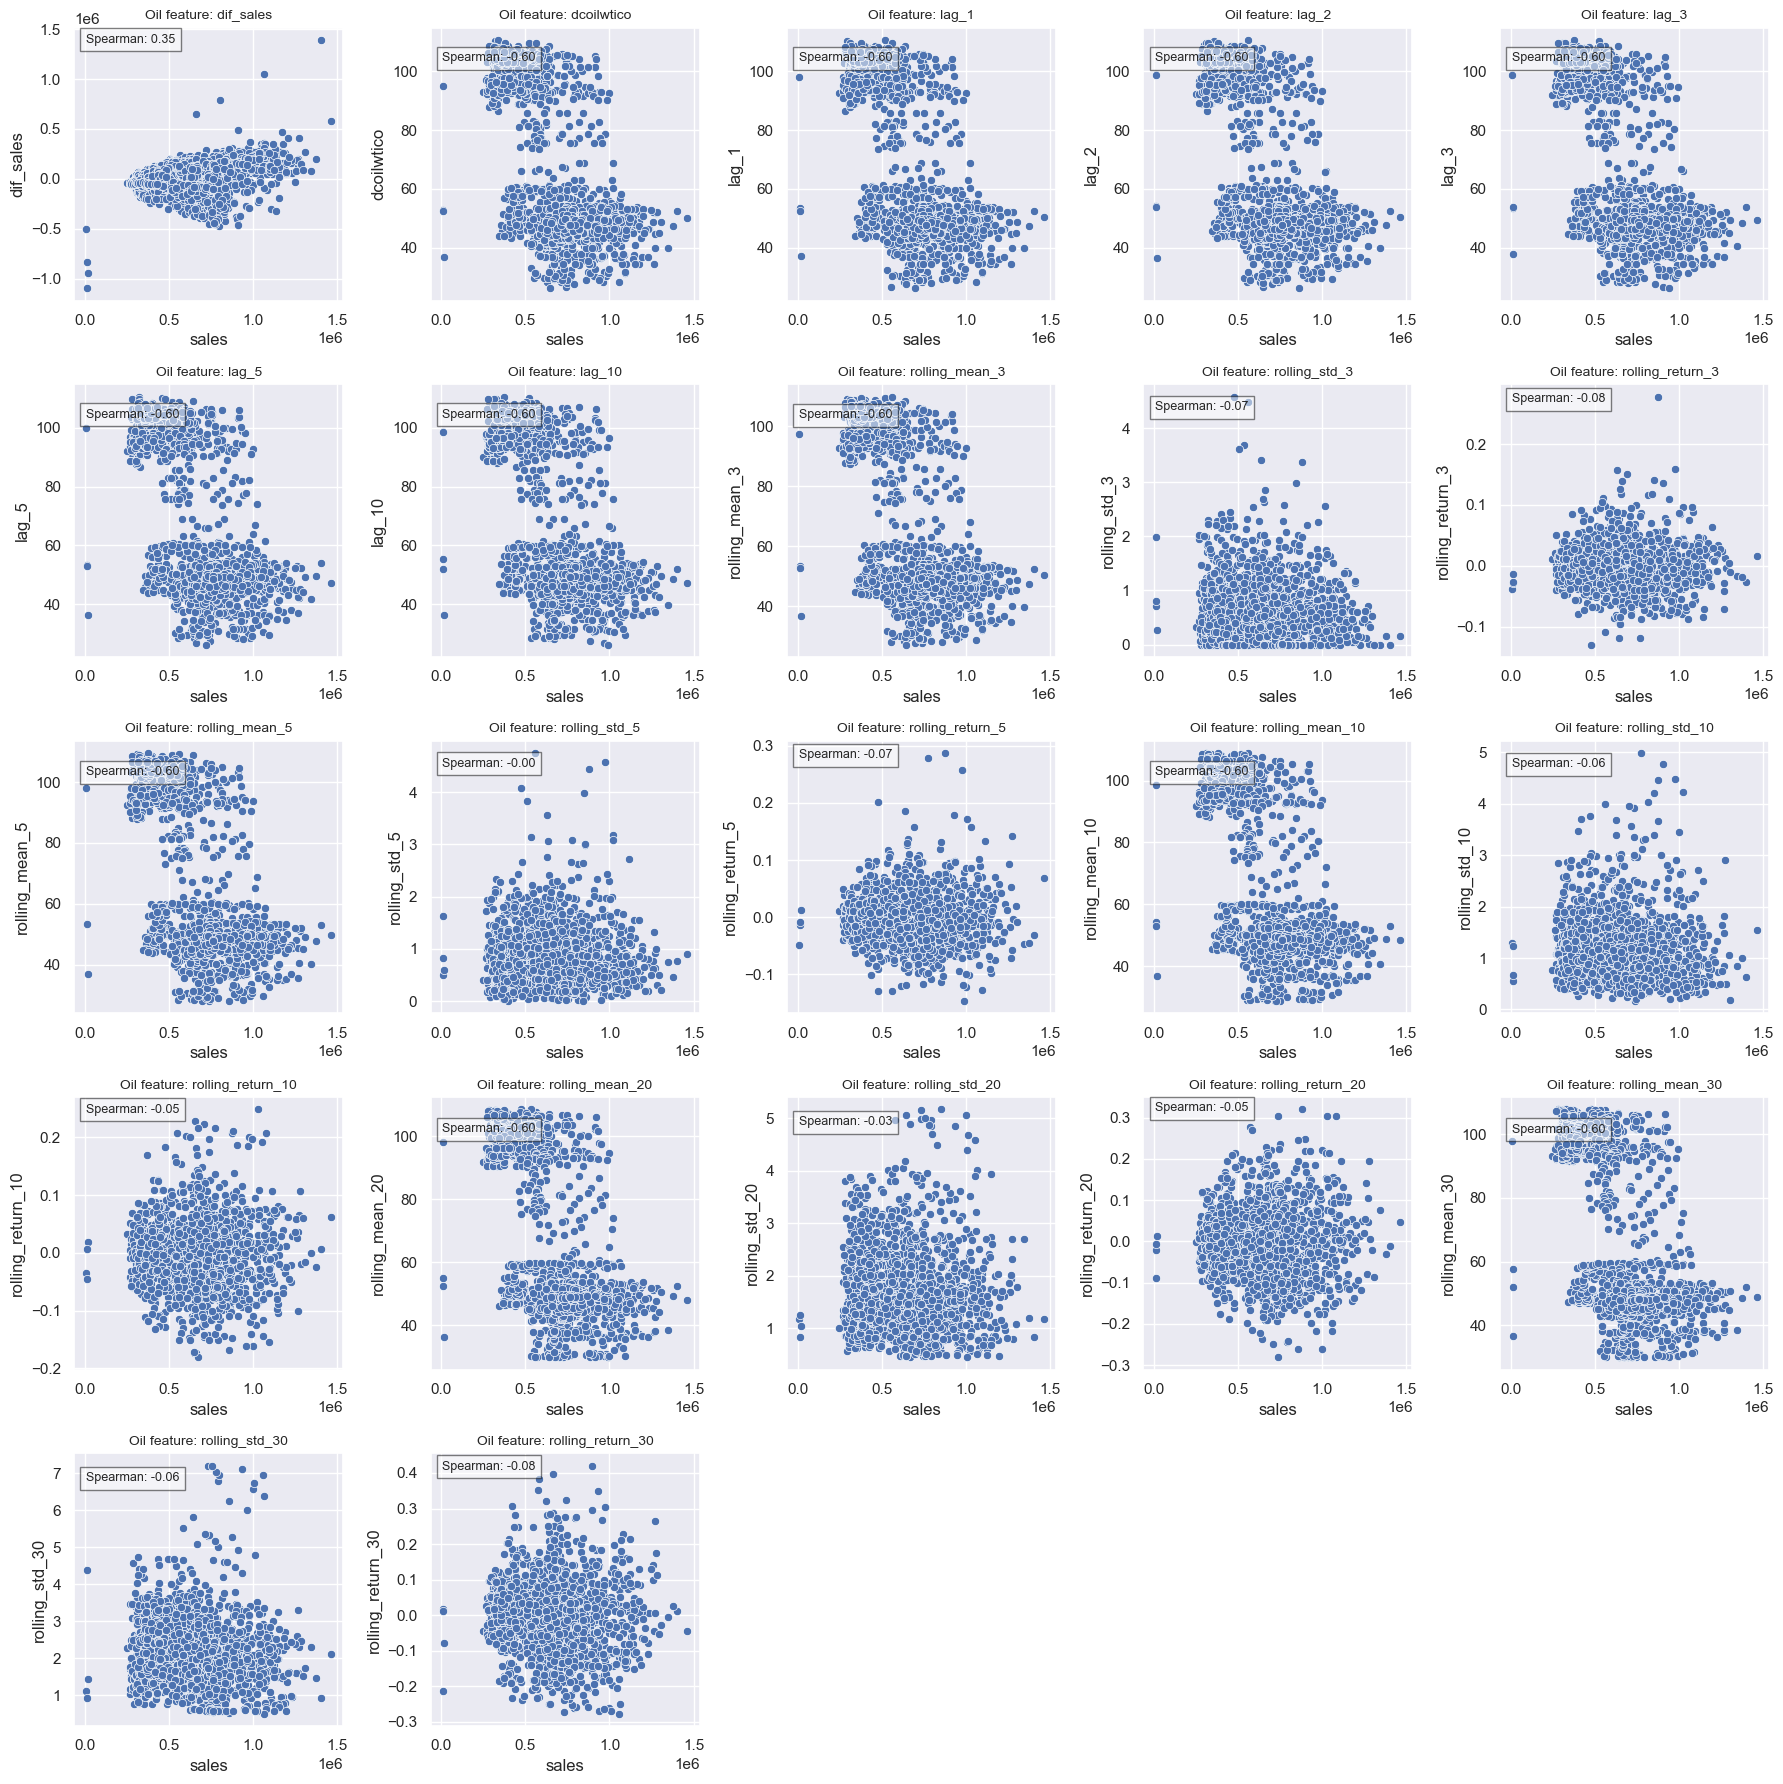

In [64]:
#### Evaluating correlation with each oil feature and sales
fig, axes = plt.subplots(5, 5, figsize=(18, 18))  # Increased figure size for better visibility
axes = axes.flatten()  # Flatten the 2D array into 1D
j = 0

for i in tt_sls_merged_df.iloc[0:,3:].columns:
    if j >= len(axes):
        break  # Avoid index error

    # Scatter plot
    sns.scatterplot(ax=axes[j], data=tt_sls_merged_df, x='sales', y=i)

    # Spearman correlation
    spearman_correlation = tt_sls_merged_df['sales'].corr(tt_sls_merged_df[i], method='spearman')
    textstr = f"Spearman: {spearman_correlation:.2f}"

    # Add correlation text
    x_pos = tt_sls_merged_df['sales'].min() * 0.7
    y_min, y_max = axes[j].get_ylim()
    y_pos = y_max * 0.9

    axes[j].text(
        x=x_pos,
        y=y_pos,
        s=textstr,
        fontsize=9,
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='black')
    )
    axes[j].set_title(f"Oil feature: {i}", fontsize=10)
    j += 1

# Hide any unused subplots
for k in range(j, len(axes)):
    axes[k].axis('off')

plt.tight_layout()
plt.show()

In [65]:
#### Getting the correlation as a table

# Get target column name
sls = tt_sls_merged_df.columns[1]

# Get correlation with other columns
oil_sls_corr = tt_sls_merged_df.corr(method='spearman')[sls]
# Drop correlation with itself
oil_sls_corr = oil_sls_corr.drop(labels=[sls])

In [66]:
### We get the absolute value of the correlation to rank their importance in the correlation eval
correl_list = abs(oil_sls_corr.drop(['date','onpromotion','dif_sales'])).sort_values(ascending = False)
correl_list
### Here we can see that the highest correlation is just the dcloilwtico without any treatment
### We can also use rolling mean an lags, but we need to be aware of adding too many features
### that have correlation between themself. Ideally the features have low correlation with each other.

dcoilwtico           0.604647
rolling_mean_10      0.604081
rolling_mean_20      0.603621
lag_1                0.603298
rolling_mean_3       0.603114
rolling_mean_30      0.602186
rolling_mean_5       0.601872
lag_2                0.600331
lag_10               0.600227
lag_5                0.600190
lag_3                0.598494
rolling_return_3     0.079384
rolling_return_30    0.077783
rolling_return_5     0.074455
rolling_std_3        0.066904
rolling_std_30       0.058473
rolling_std_10       0.057821
rolling_return_20    0.052598
rolling_return_10    0.051855
rolling_std_20       0.031326
rolling_std_5        0.002707
Name: sales, dtype: float64

In [67]:
### Getting only the selected features to test the correlation between themself
tt_sls_merged_df[list(correl_list[correl_list >= 0.5].index)].corr('spearman')

dcoilwtico  rolling_mean_10  rolling_mean_20     lag_1  \
dcoilwtico         1.000000         0.987279         0.973804  0.995105   
rolling_mean_10    0.987279         1.000000         0.992375  0.990599   
rolling_mean_20    0.973804         0.992375         1.000000  0.977522   
lag_1              0.995105         0.990599         0.977522  1.000000   
rolling_mean_3     0.997323         0.992223         0.979013  0.998773   
rolling_mean_30    0.959512         0.980012         0.994450  0.963383   
rolling_mean_5     0.994337         0.995887         0.983561  0.997016   
lag_2              0.990974         0.993091         0.980825  0.995121   
lag_10             0.960574         0.983651         0.992138  0.964255   
lag_5              0.978664         0.995845         0.988147  0.982528   
lag_3              0.986607         0.994814         0.983688  0.990983   

                 rolling_mean_3  rolling_mean_30  rolling_mean_5     lag_2  \
dcoilwtico             0.997323         0.959512        0.994337  0.990974   
rolling_mean_10        0.992223         0.980012        0.995887  0.993091   
rolling_mean_20        0.979013         0.994450        0.983561  0.980825   
lag_1                  0.998773         0.963383        0.997016  0.995121   
rolling_mean_3         1.000000         0.964751        0.998548  0.997391   
rolling_mean_30        0.964751         1.000000        0.969604  0.966994   
rolling_mean_5         0.998548         0.969604        1.000000  0.997998   
lag_2                  0.997391         0.966994        0.997998  1.000000   
lag_10                 0.965563         0.986267        0.970604  0.967711   
lag_5                  0.984325         0.976172        0.990107  0.986649   
lag_3                  0.992838         0.970355        0.997139  0.995119   

                   lag_10     lag_5     lag_3  
dcoilwtico       0.960574  0.978664  0.986607  
rolling_mean_10  0.983651  0.995845  0.994814  
rolling_mean_20  0.992138  0.988147  0.983688  
lag_1            0.964255  0.982528  0.990983  
rolling_mean_3   0.965563  0.984325  0.992838  
rolling_mean_30  0.986267  0.976172  0.970355  
rolling_mean_5   0.970604  0.990107  0.997139  
lag_2            0.967711  0.986649  0.995119  
lag_10           1.000000  0.978891  0.971275  
lag_5            0.978891  1.000000  0.991013  
lag_3            0.971275  0.991013  1.000000

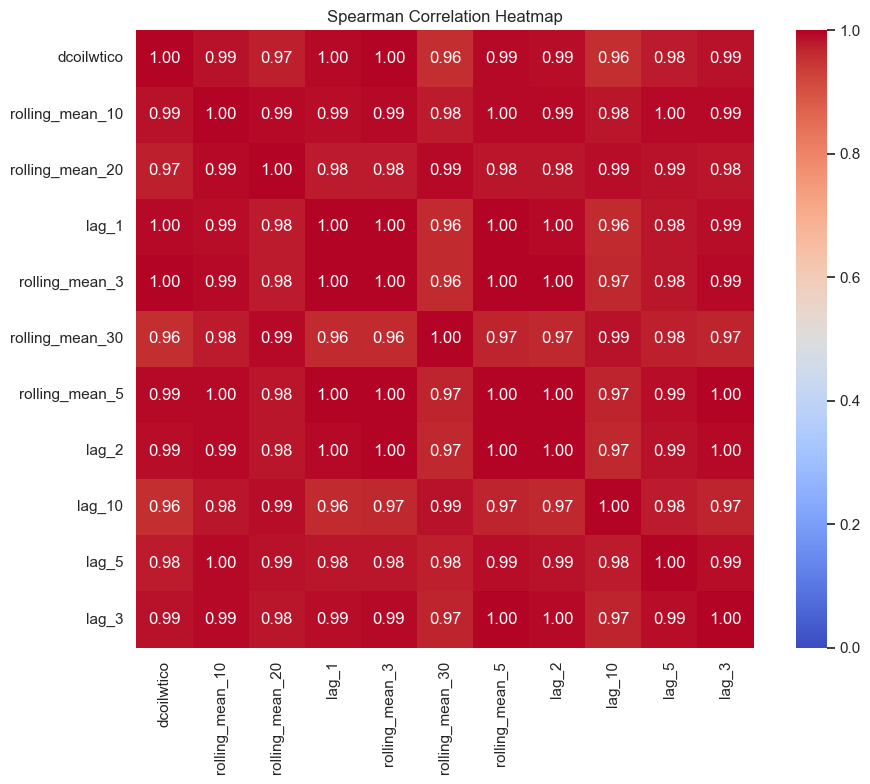

In [68]:
# Get only the columns with correlation >= 0.5 from correl_list
selected_cols = list(correl_list[correl_list >= 0.5].index)

# Compute Spearman correlation matrix for selected columns
corr_matrix = tt_sls_merged_df[selected_cols].corr(method='spearman')

# Plot heatmap
plt.figure(figsize=(10, 8))  # adjust size as needed
sns.heatmap(corr_matrix, 
            annot=True, 
            cmap='coolwarm', 
            fmt=".2f", 
            square=True,
            vmin = 0,
            vmax = 1) 
### We are using between 0 and 1 because we are getting the absolute value of the correlation

plt.title('Spearman Correlation Heatmap')
plt.tight_layout()
plt.show()


#### The conclusion if this analysis is that we can use only the dcoilwtico value, instead of creating other feature engineering for oil price